# CABECERA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from matplotlib import gridspec as gridspec
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import OneHotEncoder
import shap
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX





def separador():
    print("\n" + "=" * 170 + "\n")
def header(Titulo):
  por=((170-len(Titulo))//10)
  a=int(1.2*por)
  print("."*a+"·"*a+"~"*a+"≈"*a+"≋"
  *int(por*.2),Titulo,"≋"*int(por*.2)
  +"≈"*a+"~"*a+"·"*a+"."*a,"\n\n")

#===============================================================================================================================

# PEMEX_ANUAL

## Integración de 2016-2022

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/PDS/Morbilidad.csv', header=None, encoding='latin1')
df.iloc[8] = df.iloc[8].ffill() #Se rellenan valores
import warnings
warnings.filterwarnings("ignore")
#=================================================CREACIÓN DE GRUPOS DE EDADES=========================================
def group_age_columns_fixed(df):
    df_result = df.copy()
    # Convertir las columnas numéricas de edad a numérico de forma segura
    columnas_edad = [1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19, 20, 22, 23, 25, 26, 28, 29, 31, 32]

    for col_name in columnas_edad:
        if col_name in df.columns:
            df_result[col_name] = pd.to_numeric(df_result[col_name], errors='coerce')

    #Grupo de 0 a 15 años
    df_result['0-15_F'] = df_result[[1, 4, 7, 10]].sum(axis=1)
    df_result['0-15_M'] = df_result[[2, 5, 8, 11]].sum(axis=1)
    #Grupo de 15 a 25 años
    df_result['15-24_F'] = df_result[[13, 16]].sum(axis=1)
    df_result['15-24_M'] = df_result[[14, 17]].sum(axis=1)

    # Grupo de 25-59 años
    df_result['25-59_F'] = df_result[[19, 22, 25]].sum(axis=1)
    df_result['25-59_M'] = df_result[[20, 23, 26]].sum(axis=1)

    # Grupo de 60+ años
    df_result['60+_F'] = df_result[[28, 31]].sum(axis=1)
    df_result['60+_M'] = df_result[[29, 32]].sum(axis=1)

    return df_result

def keep_essential_columns_fixed(df_grouped):
    essential_cols = [0, 'Año']  # Columna 0 es Padecimiento, Año es la última
    new_age_cols = ['0-15_F', '0-15_M',
                   '15-24_F', '15-24_M',
                   '25-59_F', '25-59_M',
                   '60+_F', '60+_M']
    cols_to_keep = []
    for col in essential_cols + new_age_cols:
        if col in df_grouped.columns:
            cols_to_keep.append(col)

    return df_grouped[cols_to_keep]

df_agrupado = group_age_columns_fixed(df)
df = keep_essential_columns_fixed(df_agrupado)
df.fillna(0, inplace=True)

#==============================================ASIGNACIÓN DE AÑO============================================================
df['Año'] = df[0].str.extract(r'Morbilidad.*?(\d{4})', expand=False)

# Rellenar hacia adelante lo extraído, para indicar los años en todas las filas al que corresponda
df['Año'] = df['Año'].fillna(method='ffill')
año_col = df.pop('Año') # se elimina año para enviarse a la primera columna
df.insert(0, 'Año', año_col)#se inserta la columna "Año" en el indice 0, o sea en un principio

masc_mayusculas = df[0].astype(str).str.contains(r'\b[A-ZÁÉÍÓÚÑ]{2,}\b', regex=True)
#===================eliminación de 2025
try:
  indice_corte = df[df[0].str.contains('ENERO- MARZO 2025', na=False)].index
  df= df.loc[:indice_corte[0]-1]
except:
  pass

#===============================================DIVISIÓN DE DFS POR AÑOS====================================================
dfs_por_año = {año: df[df["Año"] == año] for año in df["Año"].unique()}

def division_wide_parentesis(df, año):#Procesa un DataFrame por año aplicando división, transposición y limpieza de paréntesis
    # Paso 1: División
    df_procesado = dfs_por_año[año]
    df_procesado = df_procesado.reset_index()
    df_procesado = df_procesado.drop(columns=["index", "Año"])
    df_procesado = df_procesado.set_index(0)

    # Paso 2: Transposición
    df_procesado = df_procesado.reset_index()
    df_procesado = df_procesado.rename(columns={df_procesado.columns[0]: "Grupo"})
    df_procesado = df_procesado.set_index("Grupo").T

    # Paso 3: Remoción de paréntesis
    df_procesado.columns = df_procesado.columns.str.replace(r'\([^)]*\)', '', regex=True).str.strip()
    return df_procesado

df_2016 = division_wide_parentesis(df, '2016')
df_2017 = division_wide_parentesis(df, '2017')
df_2018 = division_wide_parentesis(df, '2018')
df_2019 = division_wide_parentesis(df, '2019')
df_2020 = division_wide_parentesis(df, '2020')
df_2021 = division_wide_parentesis(df, '2021')
df_2022 = division_wide_parentesis(df, '2022')
df_2023 = division_wide_parentesis(df, '2023')
df_2024 = division_wide_parentesis(df, '2024')

#==================================================ELIMINACIÓN DE COLUMNAS CON PADECIMIENTOS AGUDOS "ENF_CRO"===============================


enf_cro=['Diabetes mellitus tipo 2', 'Diabetes mellitus tipo 1', 'Hipertensión arterial', 'Enfermedad isquémica del corazón', 'Enfermedad cerebrovascular',
         'Enfermedad pulmonar obstructiva crónica', 'Cirrosis hepática alcohólica', 'Enfermedad alcohólica del hígado', 'Asma', 'Insuficiencia venosa periférica',
         'Displasia cervical leve y moderada', 'Infección por el virus de la inmunodeficiencia humana',
         'Infección asintomática por VIH', 'Síndrome de inmunodeficiencia adquirida', 'Tuberculosis respiratoria', 'Tuberculosis otras formas',
         'Úlceras, gastritis y duodenitis',]

columnas_sin_relevancia=['Accidentes de transporte en vehículos con motor', 'Contacto traumático con avispas, avispones y abejas', 'Herida por arma de fuego y punzocortantes',
                         'Mordedura por serpiente', 'Mordeduras por otros mamíferos', 'Mordeduras por perro', 'Mordedura por otras serpientes','Enfermedad de Alzheimer'##
                         'Quemaduras', 'Peatón lesionado en accidente de transporte', 'Picadura de abeja', 'Picadura o intoxicación por otros animales ponzoñosos',
                         'Mordedura de otras arañas', 'Intoxicación aguda por alcohol', 'Intoxicación alimentaria bacteriana', 'Intoxicación por monóxido de carbono',
                         'Intoxicación por picadura de alacrán', 'Intoxicación por plaguicidas', 'Intoxicación por ponzoña de animales', 'Amebiasis intestinal',
                         'Ascariasis', 'Brucelosis', 'Chancro blando', 'Cólera', 'Conjuntivitis epidémica aguda hemorrágica', 'Cisticercosis', 'Dengue con signos de alarma',
                         'Dengue grave', 'Dengue no grave', 'Enterobiasis', 'Erisipela', 'Escabiosis', 'Escarlatina', 'Eventos supuestamente asociados a la vacunación',
                         'Fiebre paratifoidea', 'Fiebre tifoidea', 'Giardiasis', 'Hepatitis vírica A', 'Hepatitis vírica B', 'Hepatitis vírica C', 'Infección por virus Zika',
                         'Infecciones intestinales por otros organismos y las mal definidas', 'Leishmaniasis cutánea', 'Leptospirosis', 'Linfogranuloma venéreo por clamidias',
                         'Meningitis meningocócica', 'Meningitis tuberculosa', 'Otras helmintiasis', 'Otras hepatitis víricas',
                         'Otras infecciones intestinales debidas a protozoarios', 'Otras rickettsiosis', 'Otras salmonelosis', 'Paludismo por plasmodium vivax',
                         'Parotiditis infecciosa', 'Rabia humana por fauna urbana', 'Shigelosis', 'Sífilis adquirida', 'Sífilis congénita', 'Síndrome coqueluchoide',
                         'Síndrome febril', 'Síndrome meníngeo', 'Teniasis', 'Tifo epidémico', 'Toxoplasmosis', 'Tripanosomiasis americana aguda',
                         'Tripanosomiasis americana crónica', 'Varicela', 'Viruela símica', 'Bocio endémico', 'Diabetes mellitus en el embarazo',
                         'Edema, proteinuria y transtornos hipertensivos en el embarazo, parto y puerperio', 'Efectos del calor y de la luz', 'Espina bífida',
                         'Fiebre reumática aguda', 'Hipotermia', 'Labio y paladar hendido', 'Microcefalia', 'Parálisis flácida aguda', 'Tos ferina', 'Violencia intrafamiliar',

                                      'Tumor maligno de la mama', 'Tumor maligno del cuello del útero', 'Leucemia', 'Linfoma no Hodking', 'Tumor maligno de la próstata', 'Tumor maligno de riñón',
        'Tumor maligno de tráquea, bronquios y pulmón', 'Tumor maligno del colon y recto', 'Tumor maligno del cuerpo del útero', 'Tumor maligno del esófago',
        'Tumor maligno del estómago', 'Tumor maligno del ovario', 'Tumores malignos del encéfalo y de otras partes del sistema nervioso central', 'Tumor maligno del páncreas',
        'Tumor maligno del hígado y de las vías biliares intrahepáticas', 'Tumores malignos de los huesos y de los cartílagos articulares', 'Linfoma Hodking',
        'Displasia cervical severa y CaCu in situ',

                         'Enfermedad de Parkinson']

all_dfs=[df_2016,df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024]

#Se buscan coindicencias de enf_cro en todos los Dataframes
sets_por_df = [set(df.columns) for df in all_dfs]

common_enf_cro_cols = set(enf_cro).intersection(*sets_por_df)
#Para cada DataFrame, se suman únicamente esas columnas  y luego se eliminan
for df in all_dfs:
    df["cronicas"] = df[list(common_enf_cro_cols)].sum(axis=1)
    df.drop(columns=list(common_enf_cro_cols), inplace=True)


for i, df_name in enumerate(all_dfs):
    df_columnas_eliminadas = list(set(df_name.columns) & set(columnas_sin_relevancia))
    if df_columnas_eliminadas:
        df_name.drop(columns=df_columnas_eliminadas, inplace=True)
    else:
      pass

#=============================================================NUEVO DATAFRAME CON LAS COLUMNAS DE INTERÉS=====================

padecimientos = [
    'Grupo', 'Absceso hepático amebiano','Adicciones','Anorexia, bulimia y otros trastornos alimentarios','Asma','Candidiasis urogenital','Cirrosis hepática alcohólica',
    'Conjuntivitis','Depresión','Desnutrición leve','Desnutrición moderada','Desnutrición severa','Diabetes mellitus tipo 1','Diabetes mellitus tipo 2','Displasia cervical leve y moderada',
    'Enfermedad alcohólica del hígado','Enfermedad cerebrovascular','Enfermedad febril exantemática','Enfermedad isquémica del corazón',
    'Enfermedad por virus Chikungunya','Faringitis y amigdalitis estreptocócicas','Gingivitis y enfermedad periodontal','Herpes genital', 'Hiperplasia de la próstata',
    'Hipertensión arterial','Infección asintomática por VIH','Infección asociada a la atención de la salud','Infección de vías urinarias','Infección por virus del papiloma humano',
    'Infecciones respiratorias agudas','Influenza','Insuficiencia venosa periférica','Neumonías y bronconeumonías','Obesidad','Otitis media aguda','Síndrome de inmunodeficiencia adquirida',
    'Tricomoniasis urogenital','Tuberculosis otras formas','Tuberculosis respiratoria','Úlceras, gastritis y duodenitis','Vulvovaginitis', 'cancer','cronicas',
]



#==============================================================SELECCIÓN DE PADECIMIENTOS COINDICENTES================================================

# Listas de columnas para cada año (2016-2024)
cols_2016=df_2016.columns.to_list()
cols_2017=df_2017.columns.to_list()
cols_2018=df_2018.columns.to_list()
cols_2019=df_2019.columns.to_list()
cols_2020=df_2020.columns.to_list()
cols_2021=df_2021.columns.to_list()
cols_2022=df_2022.columns.to_list()
cols_2023=df_2023.columns.to_list()
cols_2024=df_2024.columns.to_list()

# Agrupar todas las listas de columnas en una sola lista
listas_de_columnas = [cols_2016, cols_2017, cols_2018, cols_2019, cols_2020, cols_2021, cols_2022, cols_2023, cols_2024]

def limpiar_lista(lista_cols):
    padecimientos_limpios = set()
    # Palabras clave a excluir que no son padecimientos
    excluir = {'Padecimiento', 'Casos', 'Total general',
               'Fuente:', 'Dirección Corporativa', 'Subdirección de Servicios',
               'Gerencia de Prevención'}

    for item in lista_cols:
        if isinstance(item, str) and not any(palabra in item for palabra in excluir) and 'Morbilidad' not in item and 'SUIVE' not in item and '20' not in item:
            # Corrección para un caso específico en las listas
            item_corregido = item.replace('Tripanosomiasis americana  crónica', 'Tripanosomiasis americana crónica')
            padecimientos_limpios.add(item_corregido)

    return padecimientos_limpios
padecimientos_comunes = limpiar_lista(padecimientos)

# Iterar sobre cada lista de columnas anual para encontrar la intersección
for lista_anual in listas_de_columnas:
    padecimientos_anuales_limpios = limpiar_lista(lista_anual)
    # Actualizar el conjunto de padecimientos comunes con la intersección
    padecimientos_comunes = padecimientos_comunes.intersection(padecimientos_anuales_limpios)

# Convertir el resultado final a una lista ordenada
padecimientos_finales_comunes = sorted(list(padecimientos_comunes))
print(f"{len(padecimientos_finales_comunes)} coincidencias")

#==================================================================NUEVOS DF CON LOS PADECIMIENTOS CORRECTOS===================================
#Nuevos df con las coindicencias de padecimientos_finales_comunes
lista_dfs=["df_2016","df_2017","df_2018","df_2019","df_2020","df_2021","df_2022","df_2023","df_2024"]

for i in range(len(lista_dfs)):
  globals()[lista_dfs[i]] = globals()[lista_dfs[i]][padecimientos_finales_comunes]

df_2023 = df_2023.groupby(df_2023.columns, axis=1).sum()#Se suman las columnas repetidas de 2023 y 2024
df_2024 = df_2024.groupby(df_2024.columns, axis=1).sum()
#se suma la columna "Año" con el año de cada df
def insertar_año(df, año):
  df.insert(0, "Año", año)
  return df
for i in range(len(lista_dfs)):
  globals()[lista_dfs[i]] = insertar_año(globals()[lista_dfs[i]], i+2016)

#=================================================================UNION DE TODOS LOS DF=======================================
lista_dfs_variable=[df_2016,df_2017, df_2018, df_2019, df_2020, df_2021, df_2022]#, df_2023, df_2024]
df= pd.concat(lista_dfs_variable)
print(df.columns.to_list())

21 coincidencias
['Año', 'Anorexia, bulimia y otros trastornos alimentarios', 'Candidiasis urogenital', 'Conjuntivitis', 'Depresión', 'Desnutrición leve', 'Desnutrición moderada', 'Desnutrición severa', 'Faringitis y amigdalitis estreptocócicas', 'Gingivitis y enfermedad periodontal', 'Herpes genital', 'Hiperplasia de la próstata', 'Infecciones respiratorias agudas', 'Infección de vías urinarias', 'Infección por virus del papiloma humano', 'Influenza', 'Neumonías y bronconeumonías', 'Obesidad', 'Otitis media aguda', 'Tricomoniasis urogenital', 'Vulvovaginitis', 'cronicas']


## EDA para pemex_anual

In [ ]:
pip install unidecode

..................··················~~~~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋≋ Filas y Columnas ≋≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~~~~··················.................. 


La base de datos consta de 56 filas y 23 columnas

...............···············~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ Nombre de las columnas y su tipo de dato ≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~···············............... 


                                 Nombre de la columna            Tipo
0                                               grupo        category
1                                             Periodo  datetime64[ns]
2   Anorexia, bulimia y otros trastornos alimentarios         float64
3                              Candidiasis urogenital         float64
4                                       Conjuntivitis         float64
5                                           Depresión         float64
6                                   Desnutrición leve         float64
7                               Desnutrición mo

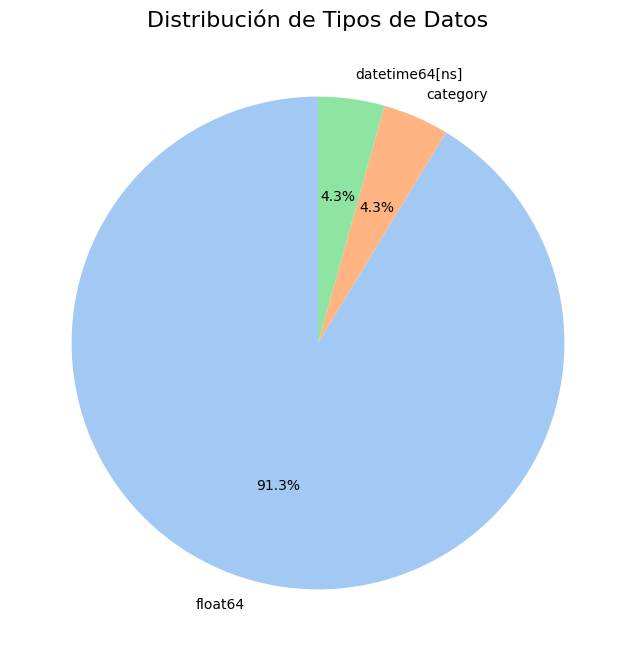

...............···············~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ Descripción Estadística del dataframe ≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~···············............... 


Grupo    grupo                        Periodo  \
count       56                             56   
unique       8                            NaN   
top     0-15_F                            NaN   
freq         7                            NaN   
mean       NaN  2019-01-01 03:25:42.857142784   
min        NaN            2016-01-01 00:00:00   
25%        NaN            2017-01-01 00:00:00   
50%        NaN            2019-01-01 00:00:00   
75%        NaN            2021-01-01 00:00:00   
max        NaN            2022-01-01 00:00:00   
std        NaN                            NaN   

Grupo   Anorexia, bulimia y otros trastornos alimentarios  \
count                                           56.000000   
unique                                                NaN   
top                                                   NaN   


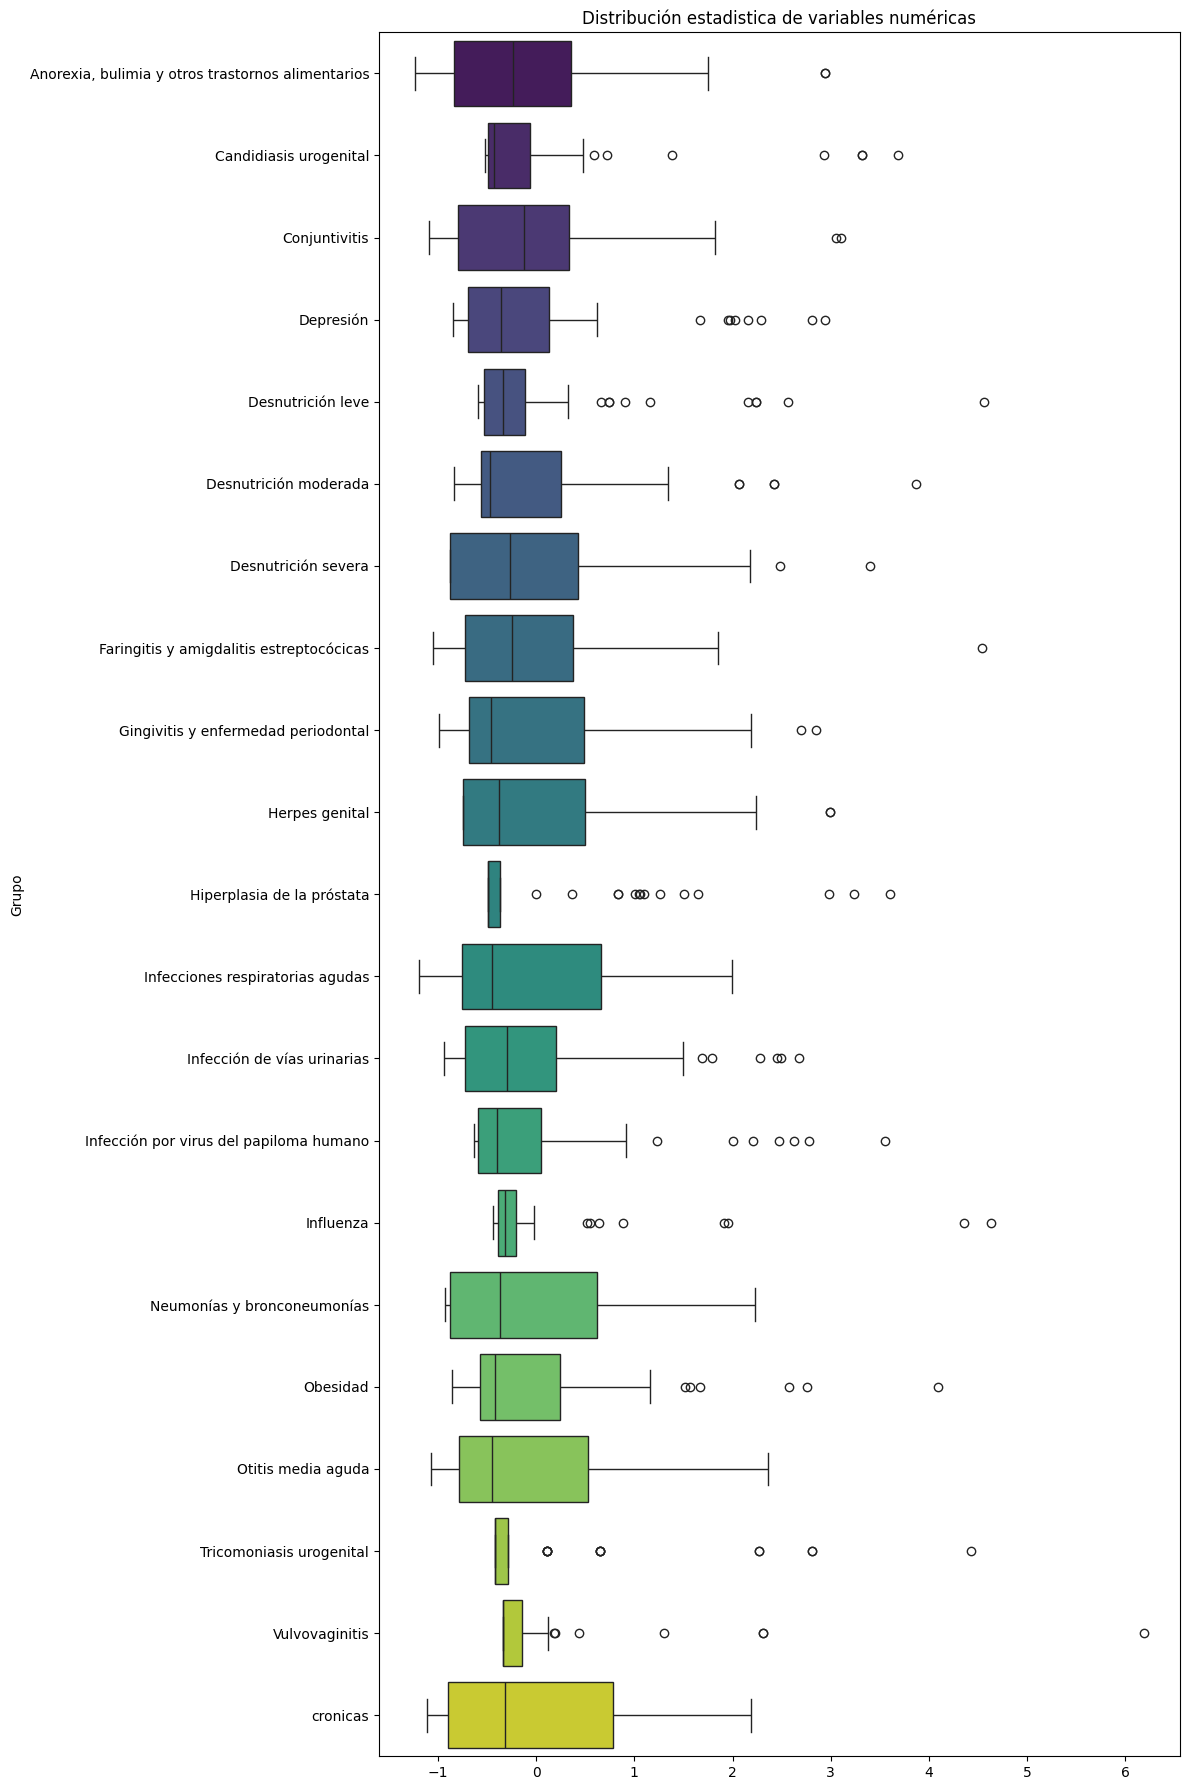

...............···············~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ Normalización de Nombres de Columnas ≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~···············............... 


Se cambia a minúsculas los nombres de las columnas
Nuevos nombres
: Index(['grupo', 'periodo', 'anorexia_bulimia_y_otros_trastornos_alimentarios',
       'candidiasis_urogenital', 'conjuntivitis', 'depresion',
       'desnutricion_leve', 'desnutricion_moderada', 'desnutricion_severa',
       'faringitis_y_amigdalitis_estreptococicas',
       'gingivitis_y_enfermedad_periodontal', 'herpes_genital',
       'hiperplasia_de_la_prostata', 'infecciones_respiratorias_agudas',
       'infeccion_de_vias_urinarias',
       'infeccion_por_virus_del_papiloma_humano', 'influenza',
       'neumonias_y_bronconeumonias', 'obesidad', 'otitis_media_aguda',
       'tricomoniasis_urogenital', 'vulvovaginitis', 'cronicas'],
      dtype='object')
................················~~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ Corrección de tipos de datos ≋≋≈

Columna  Límite Inferior  \
2   anorexia_bulimia_y_otros_trastornos_alimentarios            -7.00   
3                             candidiasis_urogenital           -43.38   
4                                      conjuntivitis         -1616.62   
5                                          depresion           -69.38   
6                                  desnutricion_leve            -6.75   
7                              desnutricion_moderada            -2.62   
8                                desnutricion_severa            -6.38   
9           faringitis_y_amigdalitis_estreptococicas           -12.38   
10               gingivitis_y_enfermedad_periodontal         -1863.88   
11                                    herpes_genital            -7.50   
12                        hiperplasia_de_la_prostata           -18.75   
13                  infecciones_respiratorias_agudas        -24905.50   
14                       infeccion_de_vias_urinarias         -4751.00   
15           infeccion_por_virus_del_papiloma_humano           -18.00   
16                                         influenza          -130.25   
17                       neumonias_y_bronconeumonias          -211.75   
18                                          obesidad          -517.50   
19                                otitis_media_aguda          -289.38   
20                          tricomoniasis_urogenital            -0.38   
21                                    vulvovaginitis          -142.12   
22                                          cronicas         -3084.88   

    Límite Superior  Número Outliers  Porcentaje (%)  
2             17.00                2            3.57  
3             77.62                7           12.50  
4           3898.38                2            3.57  
5            155.62                8           14.29  
6             13.25               10           17.86  
7              6.38                5            8.93  
8             10.62                2            3.57  
9             28.62                1            1.79  
10          4789.12                2            3.57  
11            12.50                2            3.57  
12            31.25               14           25.00  
13         63466.50                0            0.00  
14         10869.00                6           10.71  
15            32.00                7           12.50  
16           287.75                8           14.29  
17           374.25                0            0.00  
18          1500.50                6           10.71  
19           735.62                0            0.00  
20             0.62               14           25.00  
21           236.88                7           12.50  
22          6418.12                0            0.00

................················~~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ Histogramas de las columnas ≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~~················................ 




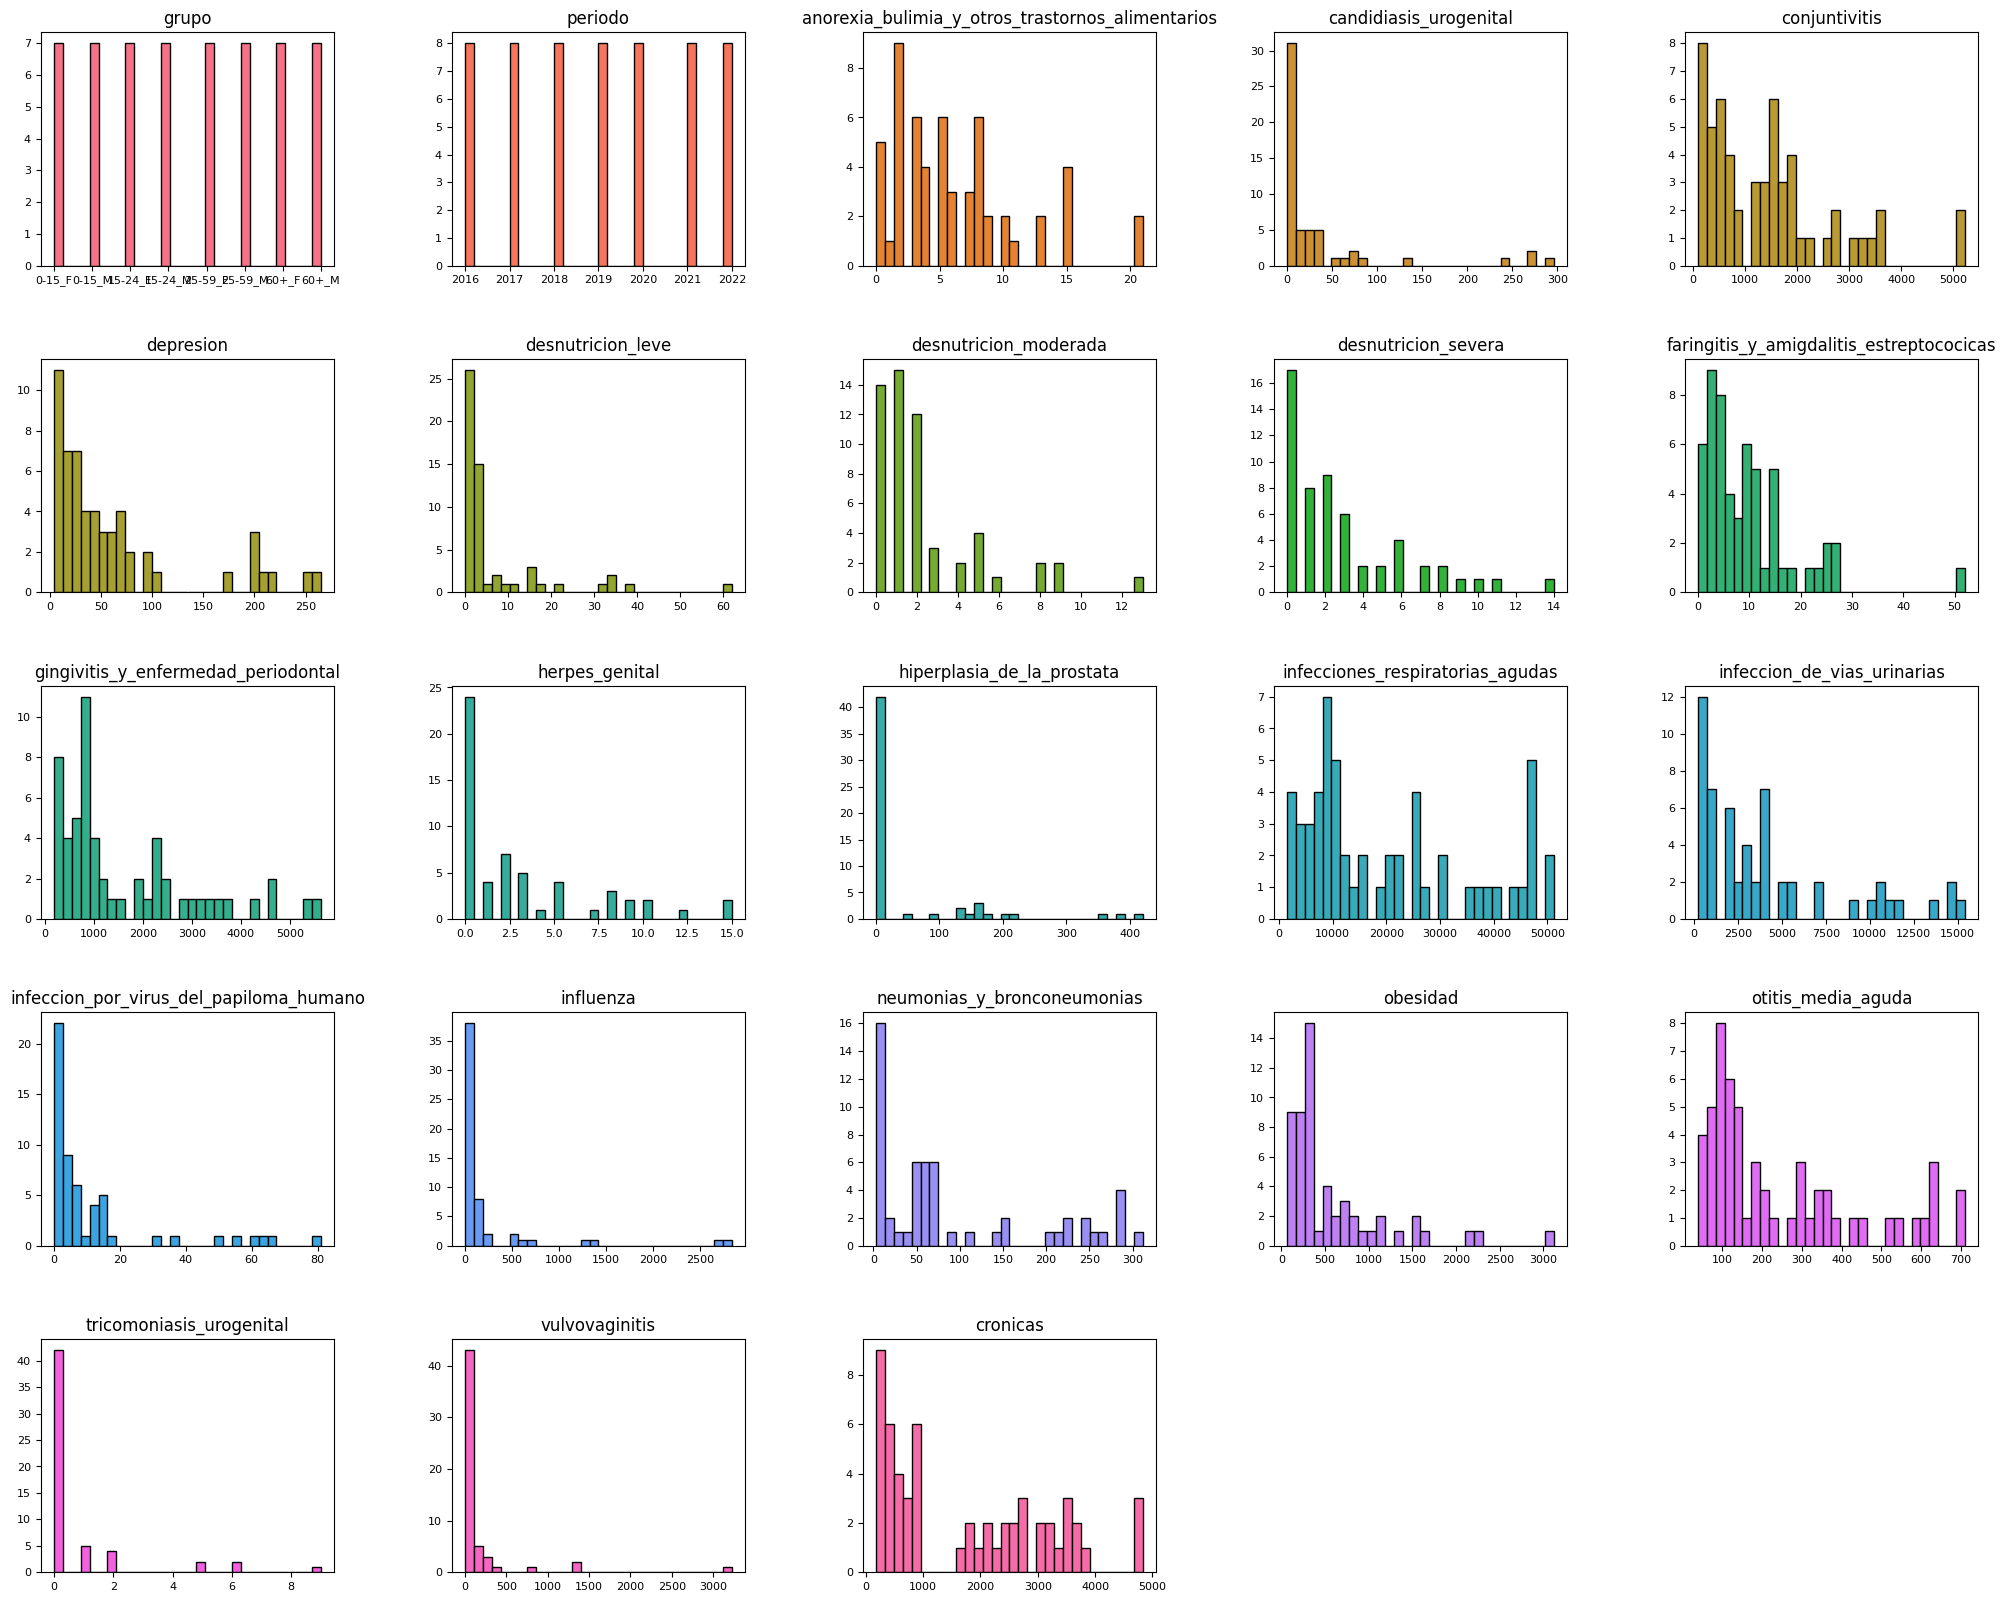

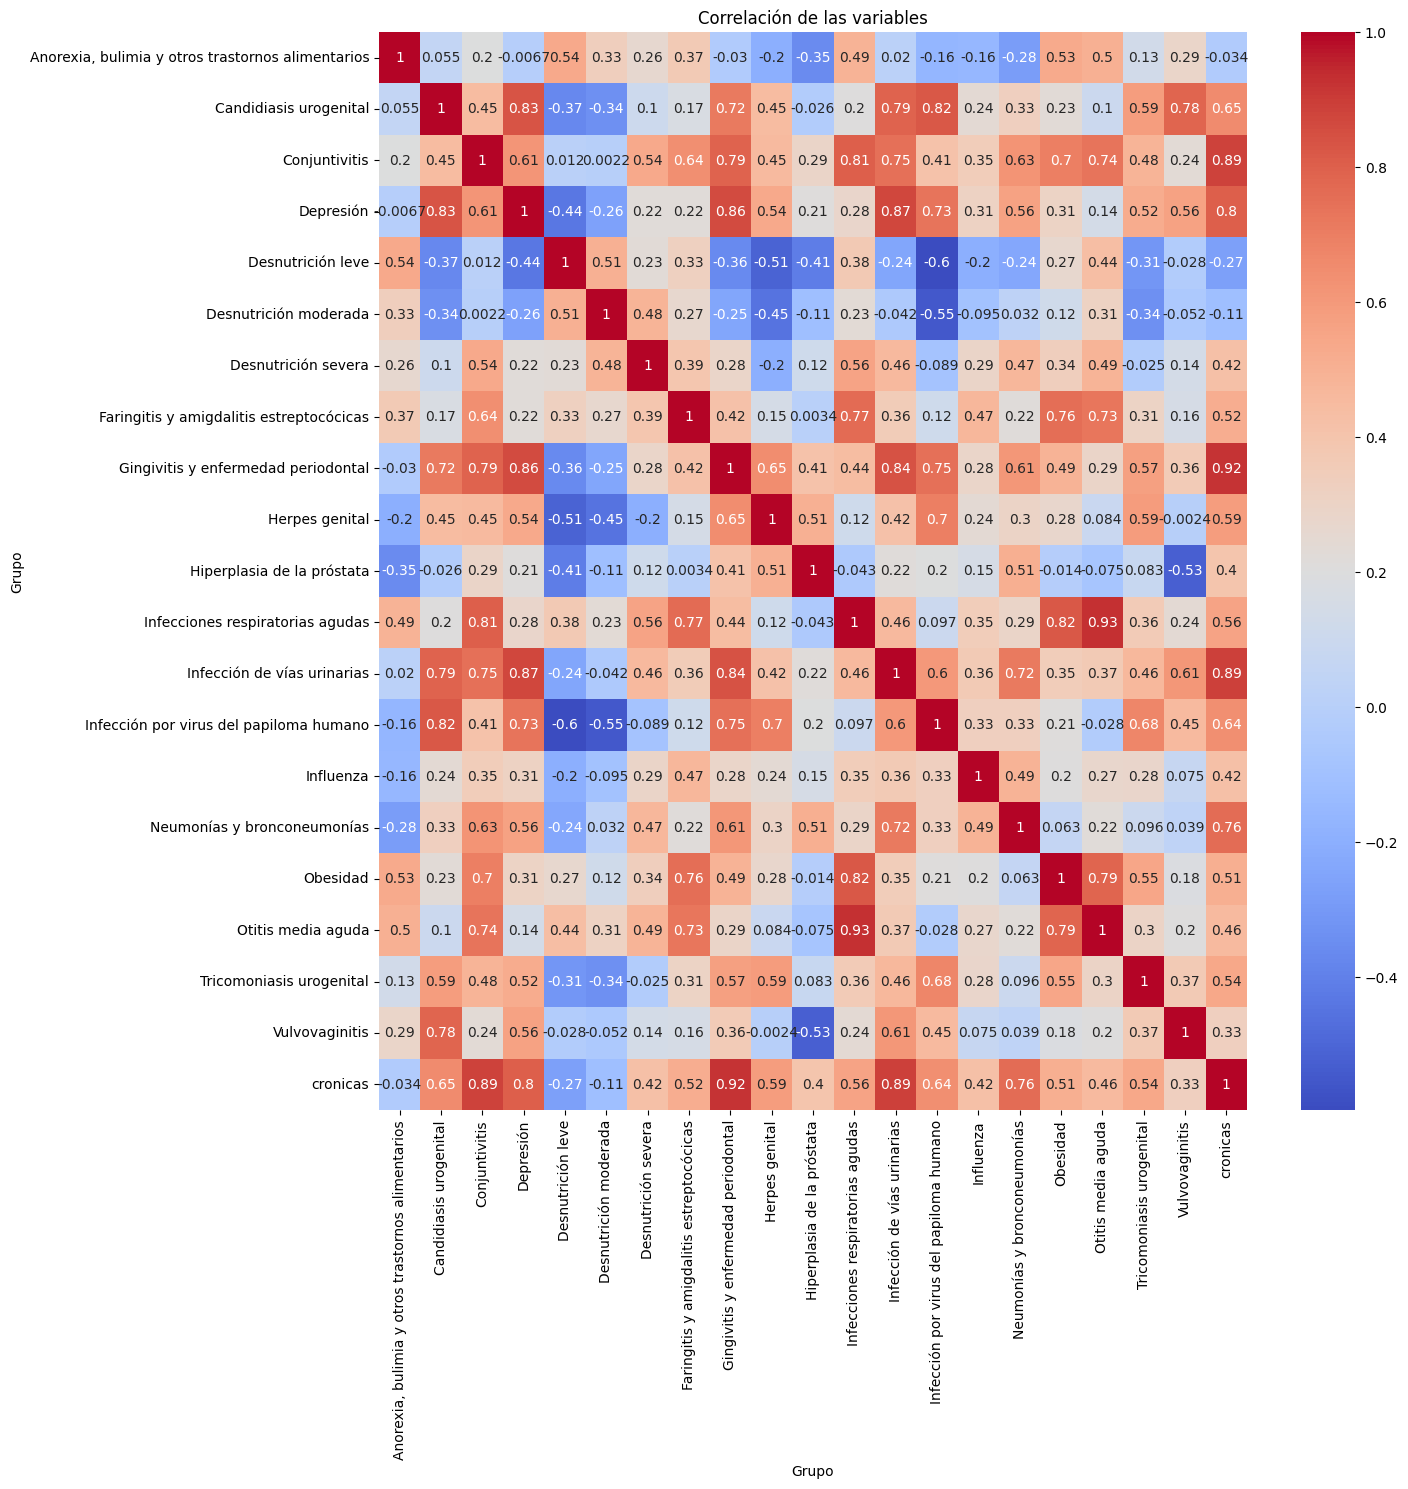

................················~~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ Distribución de las columnas ≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~~················................ 




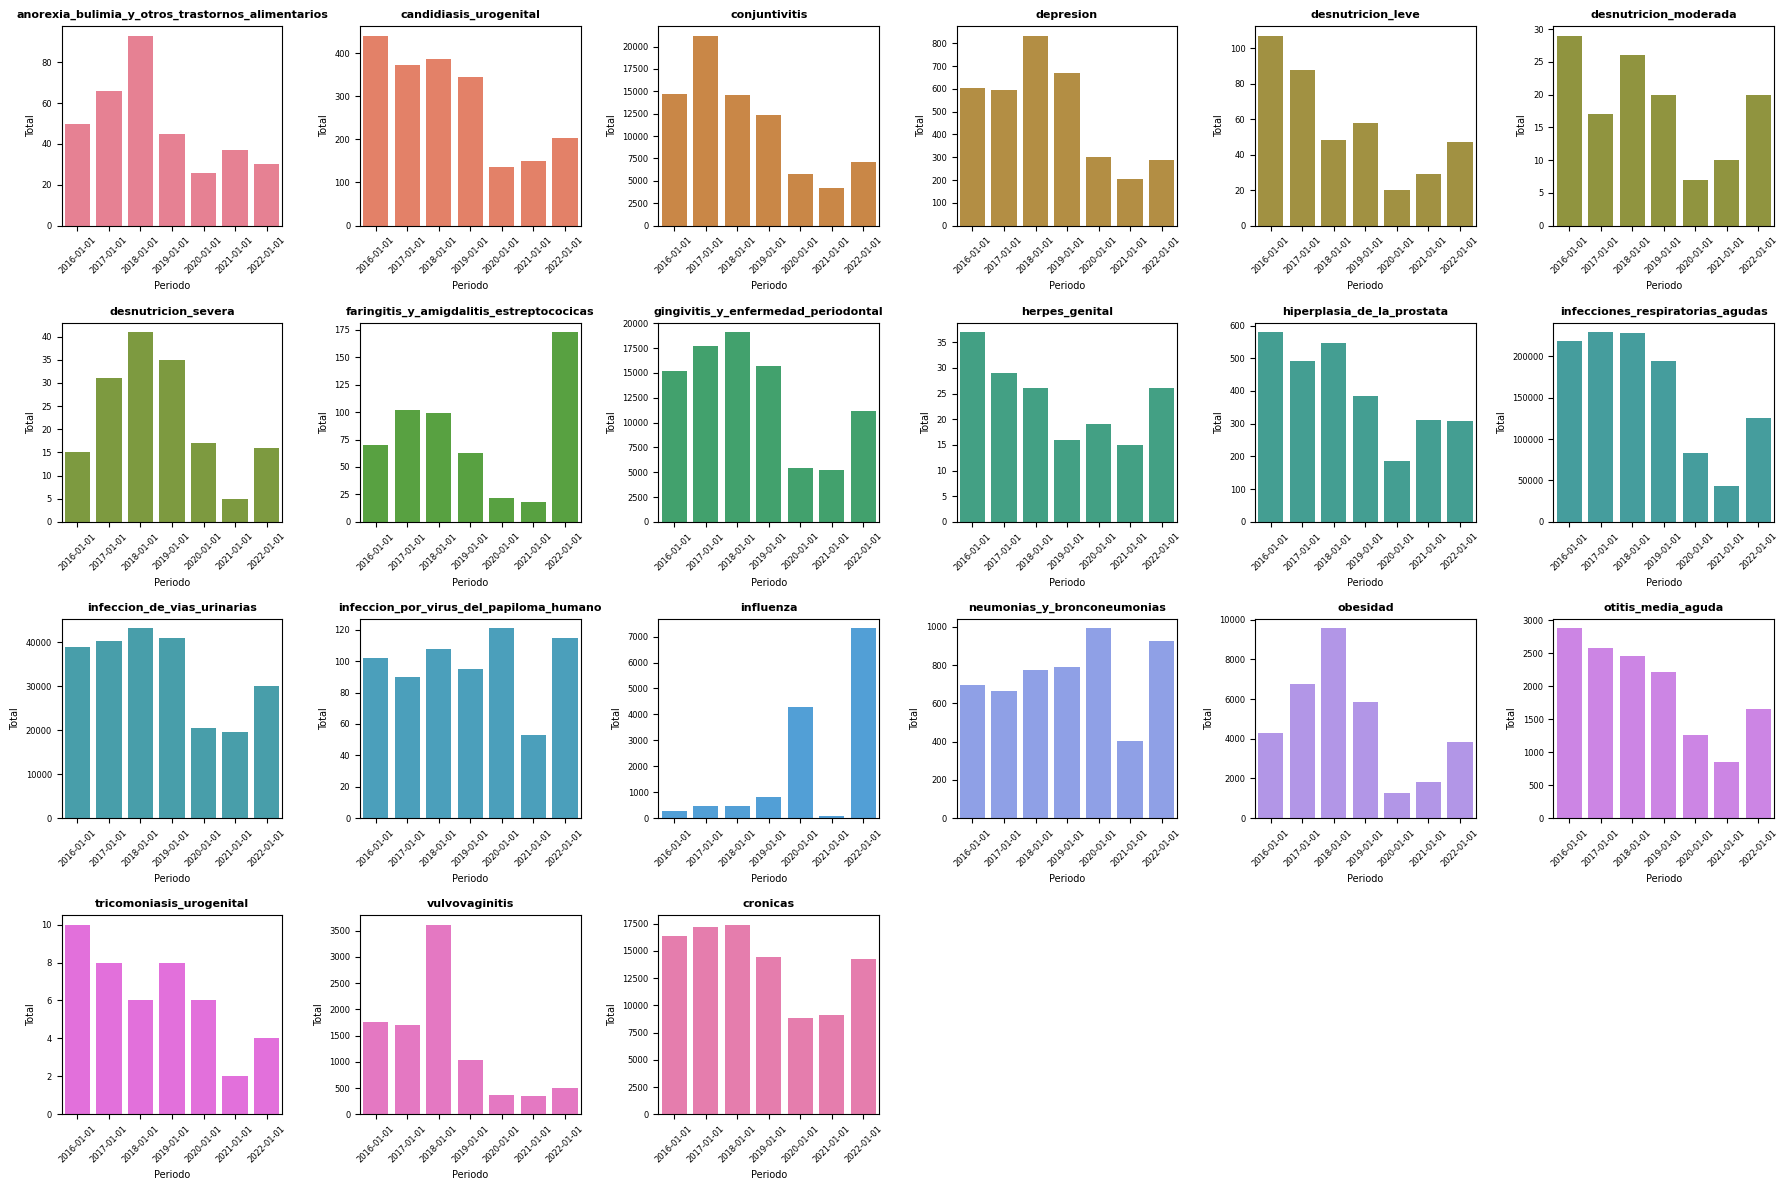

La columna grupo es de tipo category
La columna periodo es de tipo datetime64[ns]
La columna anorexia_bulimia_y_otros_trastornos_alimentarios es de tipo float64
La columna candidiasis_urogenital es de tipo float64
La columna conjuntivitis es de tipo float64
La columna depresion es de tipo float64
La columna desnutricion_leve es de tipo float64
La columna desnutricion_moderada es de tipo float64
La columna desnutricion_severa es de tipo float64
La columna faringitis_y_amigdalitis_estreptococicas es de tipo float64
La columna gingivitis_y_enfermedad_periodontal es de tipo float64
La columna herpes_genital es de tipo float64
La columna hiperplasia_de_la_prostata es de tipo float64
La columna infecciones_respiratorias_agudas es de tipo float64
La columna infeccion_de_vias_urinarias es de tipo float64
La columna infeccion_por_virus_del_papiloma_humano es de tipo float64
La columna influenza es de tipo float64
La columna neumonias_y_bronconeumonias es de tipo float64
La columna obesidad es d

In [ ]:
header('Filas y Columnas')#=================================================================================================
#se separa Grupo del index
df.reset_index(inplace=True)
df.index.name = None

df['Año']=pd.to_datetime(df['Año'], format='%Y')
#se cambia grupo a categorica
df.rename(columns={'index':'grupo'}, inplace=True)
df.rename(columns={'Año':'Periodo'}, inplace=True)
df['grupo']=df['grupo'].astype('category')

print(f'La base de datos consta de {df.shape[0]} filas y {df.shape[1]} columnas\n')
header('Nombre de las columnas y su tipo de dato')
tipos=pd.DataFrame({'Tipo':df.dtypes})
tipos.reset_index(inplace=True)
tipos.columns=['Nombre de la columna', 'Tipo']
print(tipos)
plt.figure(figsize=(8,8))
color=sns.color_palette('pastel')
df.dtypes.value_counts().plot(kind='pie', autopct='%1.1f%%', colors=color,startangle=90)
plt.title('Distribución de Tipos de Datos', size=16)
plt.ylabel('') #para que no salga etiqueta en el eje y
plt.show()


header(f'Descripción Estadística del dataframe')#============================================================================
print(df.describe(include='all'))
dfnum=df.select_dtypes(include=[np.number])#===========DFNUM
plt.figure(figsize=(12,18))
dfscal=(dfnum-dfnum.mean())/dfnum.std()
sns.boxplot(data=dfscal, orient='h', palette='viridis')
plt.title('Distribución estadistica de variables numéricas')
plt.tight_layout()
plt.show()


header('Normalización de Nombres de Columnas')#=============================================================================
df.columns = df.columns.str.lower()
#Caractéres especiales
from unidecode import unidecode
#Funcion para quitar las letras con acento, caractéres especiales y sustituir los espacios por "_"
def limpiar_nombres_columnas(df):
    # Convertir a minúsculas, quitar acentos y reemplazar espacios/caracteres especiales
    df.columns = [unidecode(col.lower()).replace(' ', '_').replace(',', '_').replace('-', '_')
                  for col in df.columns]
    # Limpiar múltiples guiones bajos consecutivos
    df.columns = [col.replace('__', '_').strip('_') for col in df.columns]
    return df
df = limpiar_nombres_columnas(df)
print(f'Se cambia a minúsculas los nombres de las columnas\nNuevos nombres\n: {df.columns}')

header('Corrección de tipos de datos')

verificar=True #pequeño bucle para verificar que todos los datos quedaran en float o int
for i in df.columns:
  if not pd.api.types.is_numeric_dtype(df[i]):
    verificar=False
    break
if verificar:
  print('\nTodas las columnas son int o float ✓\n\n')
else:
  print('No todas las columnas son int o float X')


header('Limpieza, Transformación y Normalización de Datos Categóricos')#======================================================
verificar=True
for i in df.columns:
  if not pd.api.types.is_categorical_dtype(df[i]):
    verificar=False
    break
if verificar:
  print('Hay columnas con Datos Categóricos')
else:
  print('\nNo hay columnas con Datos Categóricos\n\n')


header('Datos Perdidos')#======================================================================================================
conteo=df.isna().sum()

#porcentaje de datos perdidos por columna:
if conteo.sum()==0:
  print('\n\nNo hay Datos Perdidos\n\n')
else:
  print(f'SE ENCONTRARON: {df.isna().sum()/df.shape[0]*100}% de datos perdidos')
#Dataframe que muestra el porcentaje de los datos perdidos
if conteo.sum()!=0:
  perdidos=pd.DataFrame({'Cantidad':df.isna().sum(), 'Porcentaje':(df.isna().sum()/df.shape[0])*100})
  print(perdidos[perdidos['Cantidad']>0].sort_values('Cantidad', ascending=False))


header('Limpieza, Transformación y Normalización de Datos Temporales:')#========================================================
#bucle para verificar si tiene datos temporales:
verificar=True
for i in df.columns:
  if not pd.api.types.is_datetime64_dtype(df[i]):
    verificar=False
    break
if verificar:
  print('Hay columnas con Datos Temporales')
else:
  print('\nNo hay columnas con datos temporales\n\n')


header('Outliers')#==============================================================================================================
def analizar_outliers(df):
    # Crear un DataFrame vacío para almacenar los resultados
    resultados = pd.DataFrame(columns=['Columna', 'Límite Inferior', 'Límite Superior',
                                      'Número Outliers', 'Porcentaje (%)'])

    for i, columna in enumerate(df.columns):
      #seleccionar solo los numéricos
        if pd.api.types.is_numeric_dtype(df[columna]):
          Q1 = df[columna].quantile(0.25)
          Q3 = df[columna].quantile(0.75)
          IQR = Q3 - Q1
          limbajo = Q1 - 1.5 * IQR#límites
          limalto = Q3 + 1.5 * IQR

          outliers = df[(df[columna] < limbajo) | (df[columna] > limalto)]#se cuentan los outliers
          num_outliers = len(outliers)
          porcentaje = (num_outliers / len(df)) * 100

          resultados.loc[i] = [columna, round(limbajo, 2), round(limalto, 2),
                            num_outliers, round(porcentaje, 2)]
    return resultados

tabla_outliers = analizar_outliers(df)
display(tabla_outliers)


header('Histogramas de las columnas')#=============================================================================================
from sklearn.preprocessing import StandardScaler

columnas=df.columns.tolist()
gridcol=5
gridfil=math.ceil(len(columnas)/gridcol)
colores = sns.color_palette("husl", len(columnas))
fig = plt.figure(figsize=(5*gridcol, 4*gridfil))
gs = gridspec.GridSpec(gridfil, gridcol, figure=fig, hspace=0.4, wspace=0.4)
for i, col in enumerate(columnas):
    ax = fig.add_subplot(gs[i])
    ax.hist(df[col].dropna(), bins=30, edgecolor='black', color=colores[i])#aqui se cambia
    ax.set_title(col)
    ax.tick_params(axis='both', labelsize=8)
plt.show()

#Correlación Spearman:
plt.figure(figsize=(14,14))
sns.heatmap(dfnum.corr(method='spearman'), cmap='coolwarm', annot=True)
plt.title('Correlación de las variables')
plt.show()

#se grafica con barras en seaborn:
header('Distribución de las columnas')#============================================================================================
# Parámetros del grid
# Excluir columnas de tipo datetime del análisis
columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
n_cols   = 6
n_plots  = len(columnas_numericas)
n_rows   = int(np.ceil(n_plots / n_cols))
colores  = sns.color_palette("husl", n_plots)

# Crear figura y ejes
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(n_cols * 3, n_rows * 3),
                         squeeze=False)

#df['año'] = pd.to_datetime(df['año'])
# Iterar sobre cada columna numérica con su índice
for i, (ax, col) in enumerate(zip(axes.flatten(), columnas_numericas)):
    # Extraer el año de la columna datetime y agrupar
    valores_por_año = df.groupby('periodo')[col].sum()

    sns.barplot(
        x=valores_por_año.index.astype(str),
        y=valores_por_año.values,
        ax=ax,
        color=colores[i])

    ax.set_title(col, fontsize=8, weight='bold')
    ax.set_ylabel('Total', fontsize=7)
    ax.set_xlabel('Periodo', fontsize=7)
    ax.tick_params(axis='x', labelsize=6, rotation=45)
    ax.tick_params(axis='y', labelsize=6)

# Ocultar ejes sobrantes si hay alguno vacío
for ax in axes.flatten()[n_plots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()
#tipos de archivos
for i in df.columns:
  print(f'La columna {i} es de tipo {df[i].dtype}')

df.to_csv('/content/drive/MyDrive/PDS/pemex_prophet_all.csv', index=False)

# =================================================================================================================

# LightGBM - Feature Importances

## Modelo

In [2]:
df=pd.read_csv('/content/drive/MyDrive/PDS/pemex.csv', parse_dates=['periodo'], dtype={'grupo': 'category'})

#prepara indices y ordenar
df=df.sort_values(['grupo', 'periodo'])
df.set_index('periodo', inplace=True)


#separación de features X y y
X = df.drop('cronicas', axis=1)
y = df['cronicas']

#hold out de 20% años
años=df.index.unique().sort_values()
# Usar los últimos 2-3 años como hold-out
n_holdout = 1  # En lugar de int(len(años)*0.2)
holdout_años = años[-n_holdout:]  # 2023-2024
train_años = años[:-n_holdout]    # 2015-2022

X_train=X.loc[train_años]
X_holdout=X.loc[holdout_años]
y_train=y.loc[train_años]
y_holdout=y.loc[holdout_años]

random_states=8
#definición del modelo y espacio de busqueda
model=LGBMRegressor(objective='regression', n_estimators=500, random_state=random_states, verbose=-1)
params={
    'num_leaves':[31, 63, 127],
    'learning_rate':[0.01, 0.05, .1],
    'feature_fraction':[0.6, 0.8, 1.0],
    'bagging_fraction':[0.6, 0.8, 1.0],
    'lambda_l1':[0, 0.1, .5],
    'lambda_l2':[0, 0.1, .5],
    'min_data_in_leaf':[20, 50, 100],
    'max_depth':[3, 5, 7]}

search=RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    n_iter=50,
    cv=8,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=random_states)
#buscar hiperparametros
search.fit(X_train, y_train)

#evaluacion en hold out
best_model=search.best_estimator_
y_pred=best_model.predict(X_holdout)
mse=mean_squared_error(y_holdout, y_pred)
mae=mean_absolute_error(y_holdout, y_pred)
print(f'Hold_out period:{holdout_años.min()} to {holdout_años.max()}')
print(f'MSE: {mse}, RMSE: {np.sqrt(mse)}')
print(f'MAE: {mae}')
print(f'R2: {r2_score(y_holdout, y_pred)}')
print(f'Mejores hiperparametros: {search.best_params_}')
#se exportan las importancias para PowerBi
importances = best_model.feature_importances_
feature_names = X_train.columns
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
importances_df.to_csv('/content/drive/MyDrive/PDS/importancias_lightgbm.csv', index=False)

Lightgbm regressor
Fitting 8 folds for each of 50 candidates, totalling 400 fits
Hold_out period:2024-01-01 00:00:00 to 2024-01-01 00:00:00
MSE: 51804.644306642665, RMSE: 227.6063362620704
MAE: 162.25639422924064
R2: 0.9735359551315563
Mejores hiperparametros: {'num_leaves': 127, 'min_data_in_leaf': 20, 'max_depth': 5, 'learning_rate': 0.1, 'lambda_l2': 0.1, 'lambda_l1': 0.1, 'feature_fraction': 0.6, 'bagging_fraction': 1.0}


## Verificación LightGBM

...............···············~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ CURVAS DE VALIDACIÓN Y COMPARACIÓN DE R² ≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~···············............... 




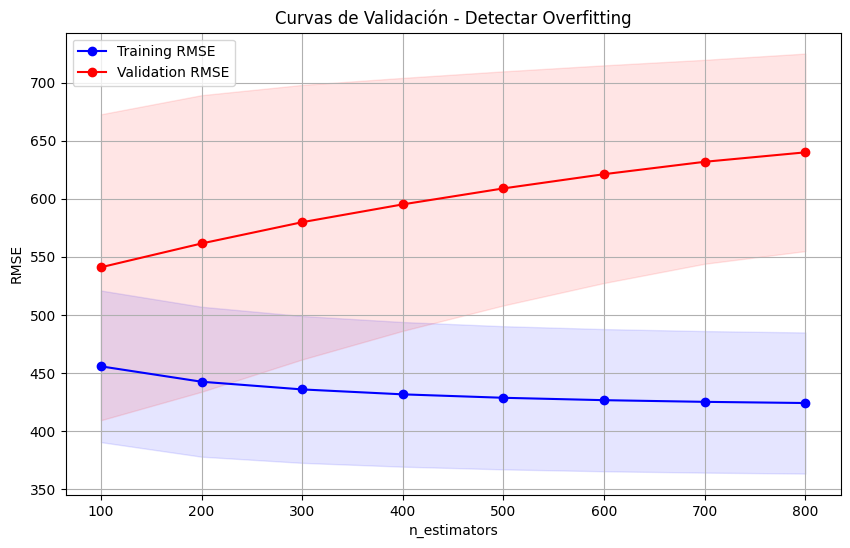

................················~~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ UNDERFITTING VS OVERFITTING ≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~~················................ 


=== DIAGNÓSTICO DE OVERFITTING ===
Training R²: 0.9868
Hold-out R²: 0.9735
Diferencia R²: 0.0133
Training RMSE: 167.56
Hold-out RMSE: 227.61
Ratio RMSE (test/train): 1.36
✅ MODELO BIEN BALANCEADO
................················~~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ CURVAS DE APRENDIZAJE ≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~~················................ 




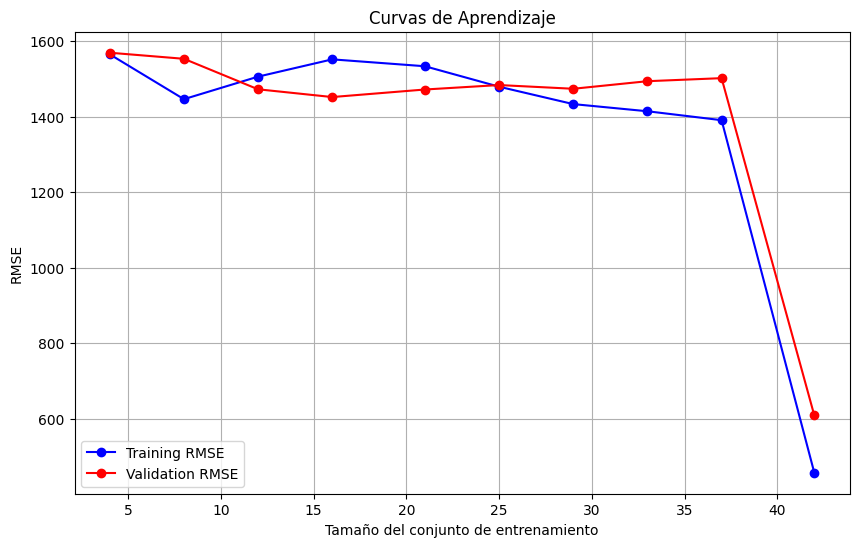

..................··················~~~~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋≋ ANALISIS DE RESIDUOS ≋≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~~~~··················.................. 




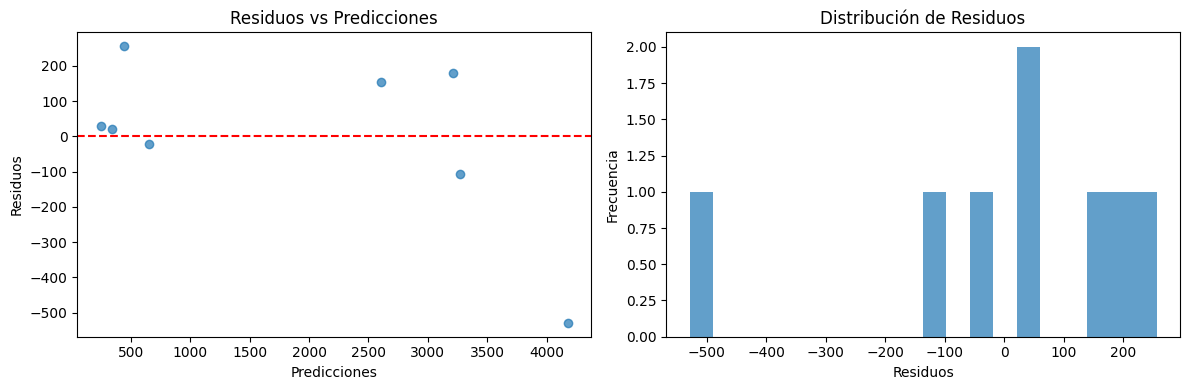

................················~~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ ANÁLISIS DE DISTRIBUCIONES ≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~~················................ 


Training - Media: 1825.86, Std: 1470.74
Hold-out - Media: 1866.62, Std: 1495.73
Training - Rango: 177.00 - 4978.00
Hold-out - Rango: 275.00 - 3648.00


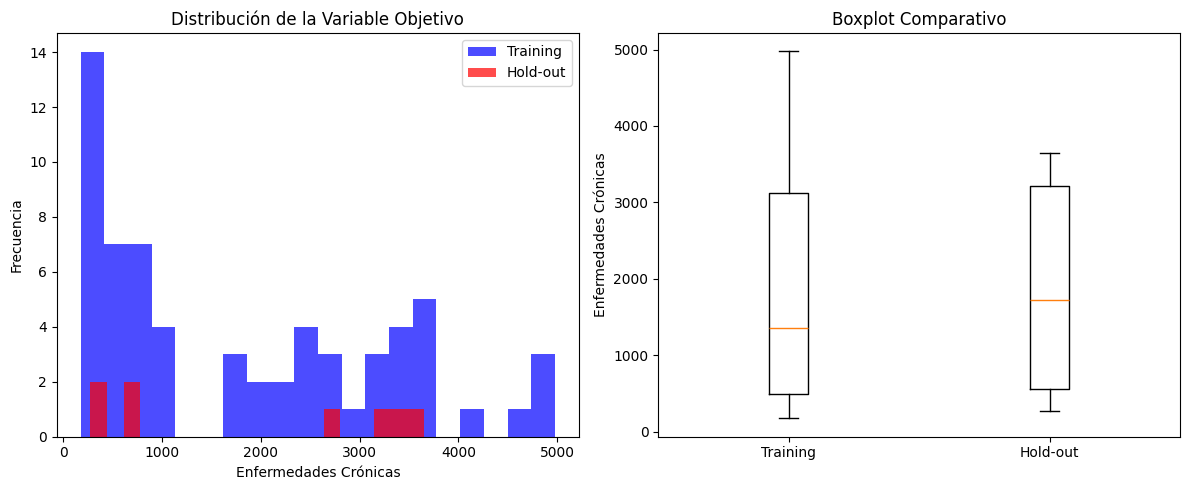

In [ ]:

header('CURVAS DE VALIDACIÓN Y COMPARACIÓN DE R²')

# Probar diferentes valores de n_estimators
param_range = [100, 200, 300, 400, 500, 600, 700, 800]
train_scores, val_scores = validation_curve(
    LGBMRegressor(random_state=11, verbose=-1),
    X_train, y_train,
    param_name='n_estimators',
    param_range=param_range,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Convertir a positivo
train_scores = -train_scores
val_scores = -val_scores

# Calcular medias y desviaciones
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, 'o-', color='blue', label='Training RMSE')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(param_range, val_mean, 'o-', color='red', label='Validation RMSE')
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('Curvas de Validación - Detectar Overfitting')
plt.legend()
plt.grid(True)
plt.show()


#==============================================================================================
header('UNDERFITTING VS OVERFITTING')
# Se evalua en datos de entrenamiento
y_train_pred = best_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Evaluar en hold-out
holdout_r2 = r2_score(y_holdout, y_pred)
holdout_rmse = np.sqrt(mean_squared_error(y_holdout, y_pred))

print(f"Training R²: {train_r2:.4f}")
print(f"Hold-out R²: {holdout_r2:.4f}")
print(f"Diferencia R²: {train_r2 - holdout_r2:.4f}")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Hold-out RMSE: {holdout_rmse:.2f}")
print(f"Ratio RMSE (test/train): {holdout_rmse/train_rmse:.2f}")

# Interpretación
if train_r2 - holdout_r2 > 0.1:
    print("⚠️  POSIBLE OVERFITTING")
elif holdout_r2 > train_r2:
    print("⚠️ POSIBLE UNDERFITTING o datos test más fáciles")
else:
    print("✅ MODELO BIEN BALANCEADO")

#===========================================================================================================
header('CURVAS DE APRENDIZAJE')
from sklearn.model_selection import learning_curve

# Curvas de aprendizaje
train_sizes, train_scores_lc, val_scores_lc = learning_curve(
    best_model, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1)

# Convertir a positivo
train_scores_lc = -train_scores_lc
val_scores_lc = -val_scores_lc

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores_lc, axis=1), 'o-', color='blue', label='Training RMSE')
plt.plot(train_sizes, np.mean(val_scores_lc, axis=1), 'o-', color='red', label='Validation RMSE')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('RMSE')
plt.title('Curvas de Aprendizaje')
plt.legend()
plt.grid(True)
plt.show()
#==========================================================================================
header('ANALISIS DE RESIDUOS')
# Residuos en hold-out
residuals = y_holdout - y_pred

plt.figure(figsize=(12, 4))

# Subplot 1: Residuos vs Predicciones
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Residuos vs Predicciones')

# Subplot 2: Histograma de residuos
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20, alpha=0.7)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Distribución de Residuos')

plt.tight_layout()
plt.show()
#==================================================================================================
# Analizar diferencias en distribuciones
header('ANÁLISIS DE DISTRIBUCIONES')
print(f"Training - Media: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Hold-out - Media: {y_holdout.mean():.2f}, Std: {y_holdout.std():.2f}")
print(f"Training - Rango: {y_train.min():.2f} - {y_train.max():.2f}")
print(f"Hold-out - Rango: {y_holdout.min():.2f} - {y_holdout.max():.2f}")

# Visualización de distribuciones
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=20, alpha=0.7, label='Training', color='blue')
plt.hist(y_holdout, bins=20, alpha=0.7, label='Hold-out', color='red')
plt.xlabel('Enfermedades Crónicas')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Variable Objetivo')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot([y_train, y_holdout], labels=['Training', 'Hold-out'])
plt.ylabel('Enfermedades Crónicas')
plt.title('Boxplot Comparativo')
plt.tight_layout()
plt.show()

## SHAP (XAI) LightGBM



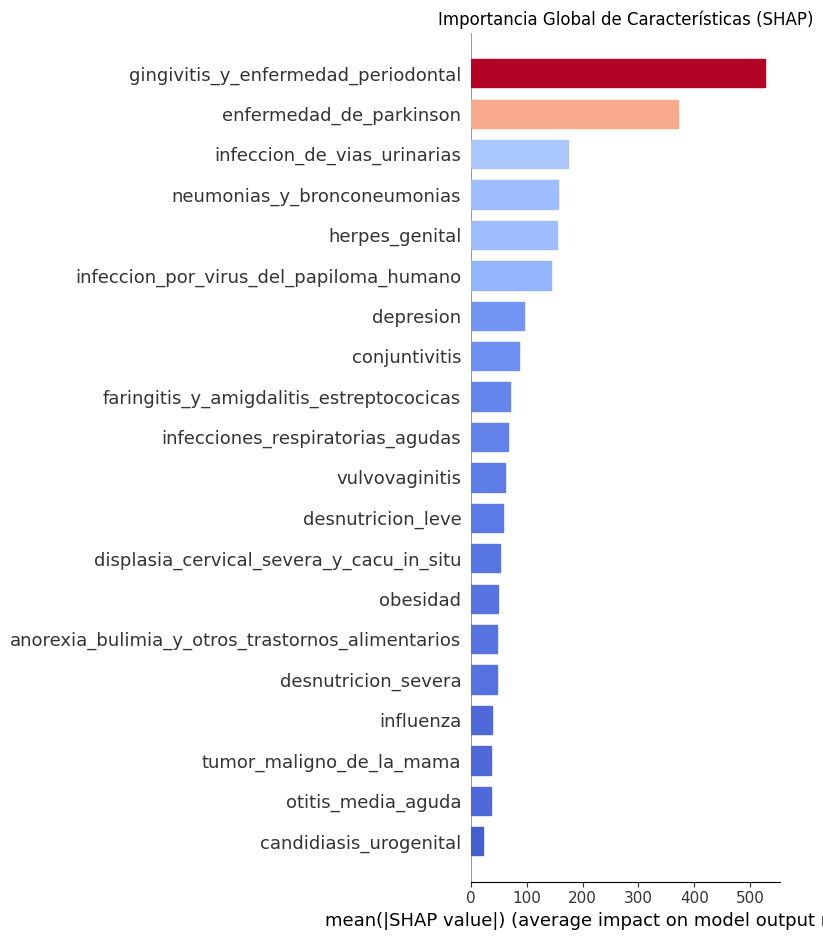

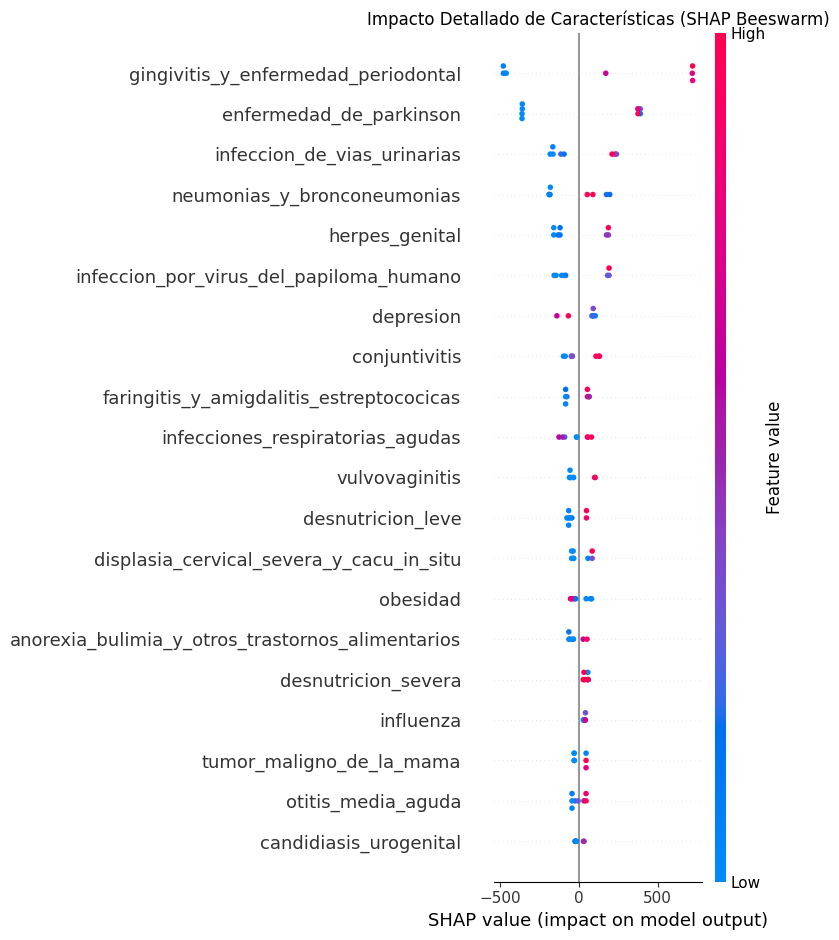

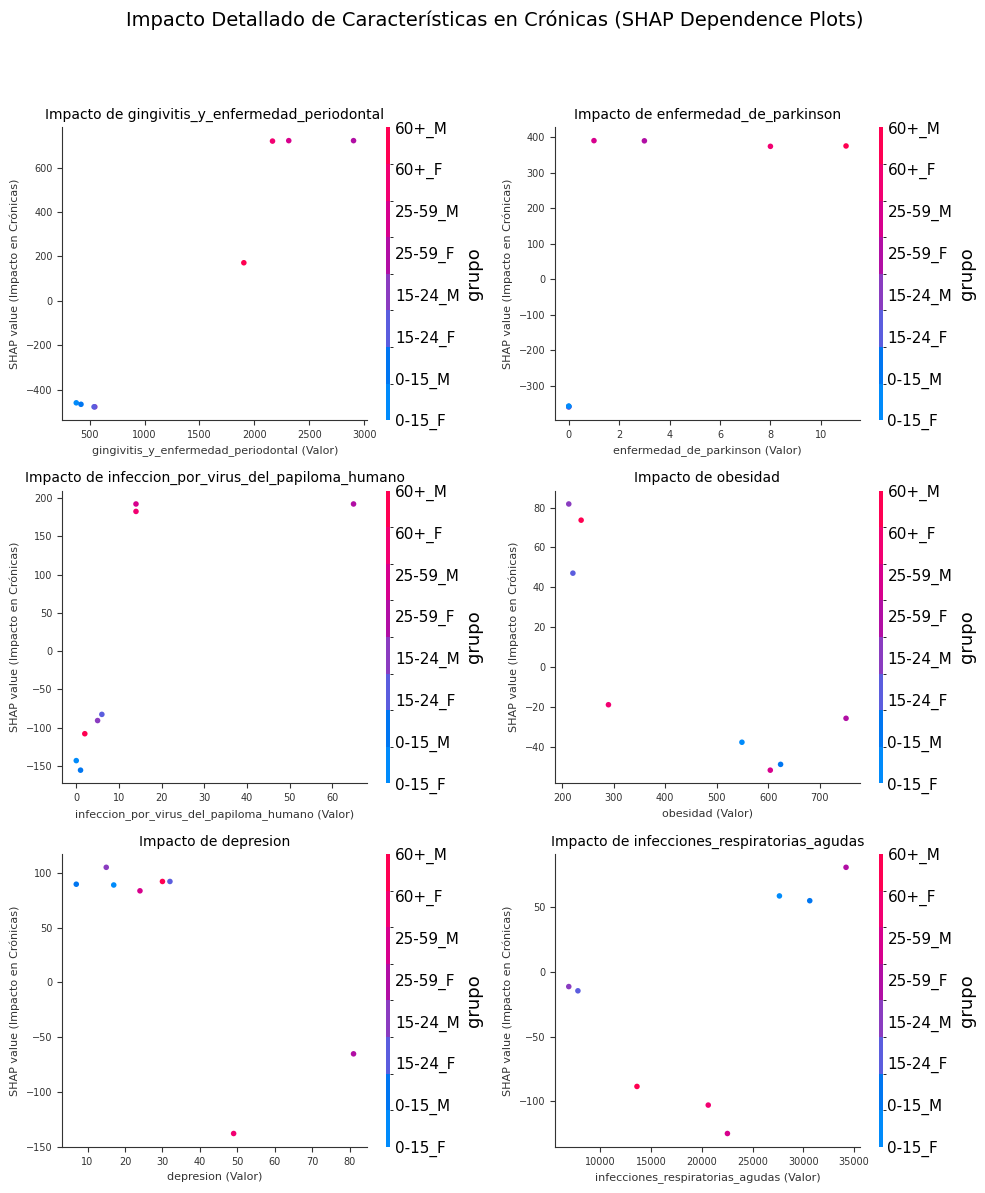

In [ ]:

X_shap = X_holdout

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_shap)

# Gráfico de barras
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
plt.title("Importancia Global de Características (SHAP)")


# Agregar colormap a las barras
ax = plt.gca()
bars = ax.patches
values = [bar.get_width() for bar in bars]
colors = plt.cm.coolwarm([v/max(values) for v in values]) #aqui la paleta
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.tight_layout()
plt.show()

# Beeswarm plot detallado
shap.summary_plot(shap_values, X_shap, show=False)
plt.title("Impacto Detallado de Características (SHAP Beeswarm)")
plt.tight_layout()
plt.show()



lista_de_caracteristicas = [
    'gingivitis_y_enfermedad_periodontal',
    'enfermedad_de_parkinson',
    'infeccion_por_virus_del_papiloma_humano',
    'obesidad',
    'depresion',
    'infecciones_respiratorias_agudas'# Agrega más características según necesites
]

num_features = len(lista_de_caracteristicas)
num_cols = 2  # Número de columnas deseadas en el grid
num_rows = (num_features + num_cols - 1) // num_cols # Calcula el número de filas necesario

# Crear la figura y los subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))

axes = axes.flatten()

# Itera sobre la lista de características y crea un dependence plot para cada una
for i, feature_name in enumerate(lista_de_caracteristicas):
    if i < len(axes)
        ax = axes[i]

        shap.dependence_plot(
            feature_name,
            shap_values,
            X_shap,
            ax=ax,
            show=False,
            interaction_index="auto"
        )

        ax.set_title(f'Impacto de {feature_name}', fontsize=10)
        ax.set_xlabel(f'{feature_name} (Valor)', fontsize=8)
        ax.set_ylabel('SHAP value (Impacto en Crónicas)', fontsize=8)

        # Ajusta el tamaño de los ticks para que no se superpongan
        ax.tick_params(axis='x', labelsize=7)
        ax.tick_params(axis='y', labelsize=7)

# Oculta los subplots vacíos si el número de características no llena el grid
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Impacto Detallado de Características en Crónicas (SHAP Dependence Plots)", fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Ajusta el layout para la super-título
plt.show()

# ================================================================================================


# PEMEX_TRIMESTRALES

## df_trimestres

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/PDS/Morbilidad.csv', header=None, encoding='latin1')
df.iloc[8] = df.iloc[8].ffill() #Se rellenan valores
import warnings
warnings.filterwarnings("ignore")
#=================================================CREACIÓN DE GRUPOS DE EDADES=========================================
def group_age_columns_fixed(df):
    df_result = df.copy()
    # Convertir las columnas numéricas de edad a numérico de forma segura
    columnas_edad = [1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19, 20, 22, 23, 25, 26, 28, 29, 31, 32]

    for col_name in columnas_edad:
        if col_name in df.columns:
            df_result[col_name] = pd.to_numeric(df_result[col_name], errors='coerce')

    #Grupo de 0 a 15 años
    df_result['0-15_F'] = df_result[[1, 4, 7, 10]].sum(axis=1)
    df_result['0-15_M'] = df_result[[2, 5, 8, 11]].sum(axis=1)
    #Grupo de 15 a 25 años
    df_result['15-24_F'] = df_result[[13, 16]].sum(axis=1)
    df_result['15-24_M'] = df_result[[14, 17]].sum(axis=1)

    # Grupo de 25-59 años
    df_result['25-59_F'] = df_result[[19, 22, 25]].sum(axis=1)
    df_result['25-59_M'] = df_result[[20, 23, 26]].sum(axis=1)

    # Grupo de 60+ años
    df_result['60+_F'] = df_result[[28, 31]].sum(axis=1)
    df_result['60+_M'] = df_result[[29, 32]].sum(axis=1)

    return df_result

def keep_essential_columns_fixed(df_grouped):
    essential_cols = [0, 'Año']  # Columna 0 es Padecimiento, Año es la última
    new_age_cols = ['0-15_F', '0-15_M',
                   '15-24_F', '15-24_M',
                   '25-59_F', '25-59_M',
                   '60+_F', '60+_M']
    cols_to_keep = []
    for col in essential_cols + new_age_cols:
        if col in df_grouped.columns:
            cols_to_keep.append(col)

    return df_grouped[cols_to_keep]

df_agrupado = group_age_columns_fixed(df)
df = keep_essential_columns_fixed(df_agrupado)
df.fillna(0, inplace=True)

#==============================================ASIGNACIÓN DE AÑO============================================================
df['Año'] = df[0].str.extract(r'Morbilidad.*?(\d{4})', expand=False)
# Rellenar hacia adelante lo extraído, para indicar los años en todas las filas al que corresponda
df['Año'] = df['Año'].fillna(method='ffill')

# Patrón que busca específicamente nombres de meses conocidos
patron_mes_año = r'(\b[A-ZÁÉÍÓÚÑ]{2,}-[A-ZÁÉÍÓÚÑ]{2,}\s+202\d\b)'
periodos_extraidos = df[0].astype(str).str.extract(patron_mes_año)
df['periodo']=periodos_extraidos
df['periodo'] = df['periodo'].fillna(method='ffill')
trim_col = df.pop('periodo') # se elimina año para enviarse a la primera columna
df.insert(0, 'periodo', trim_col)

#Se eliminan las filas donde año = 2016, 2017, 2018, 2019, 2020, 2021, 2022, porque no son de interés para prophet
df = df[~df['Año'].isin(['2016', '2017', '2018', '2019', '2020', '2021', '2022'])]
#se elimina la columna año
df.drop(columns=['Año'], inplace=True)
#===============================================DIVISIÓN DE DFS POR AÑOS====================================================
dfs_trimestre = {trim: df[df["periodo"] == trim] for trim in df["periodo"].unique()}

def division_wide_parentesis(df, trim):

    #Se divide en años
    df_procesado = dfs_trimestre[trim]
    df_procesado = df_procesado.reset_index()
    df_procesado = df_procesado.drop(columns=["index", "periodo"])
    df_procesado = df_procesado.set_index(0)

    #Se transponen las divisiones previas
    df_procesado = df_procesado.reset_index()
    df_procesado = df_procesado.rename(columns={df_procesado.columns[0]: "Grupo"})
    df_procesado = df_procesado.set_index("Grupo").T

    #Se quita los parentesis
    df_procesado.columns = df_procesado.columns.str.replace(r'\([^)]*\)', '', regex=True).str.strip()
    return df_procesado

df_1 = division_wide_parentesis(df, 'ENERO-MARZO 2023')
df_2 = division_wide_parentesis(df, 'ABRIL-JUNIO 2023')
df_3 = division_wide_parentesis(df, 'JULIO-SEPTIEMBRE 2023')
df_4 = division_wide_parentesis(df, 'OCTUBRE-DICIEMBRE 2023')
df_5 = division_wide_parentesis(df, 'ENERO-MARZO 2024')
df_6 = division_wide_parentesis(df, 'ABRIL-JUNIO 2024')
df_7 = division_wide_parentesis(df, 'JULIO-SEPTIEMBRE 2024')
df_8 = division_wide_parentesis(df, 'OCTUBRE-DICIEMBRE 2024')
df_9 = division_wide_parentesis(df, 'ENERO-MARZO 2025')


#print(f'DF_2023 en division wide: \n{df_1.head(10).to_string()}')

#==================================================ELIMINACIÓN DE COLUMNAS CON PADECIMIENTOS AGUDOS "ENF_CRO"===============================


enf_cro=['Diabetes mellitus tipo 2', 'Diabetes mellitus tipo 1', 'Hipertensión arterial', 'Enfermedad isquémica del corazón', 'Enfermedad cerebrovascular',
         'Enfermedad pulmonar obstructiva crónica', 'Cirrosis hepática alcohólica', 'Enfermedad alcohólica del hígado', 'Asma', 'Insuficiencia venosa periférica',
         'Displasia cervical leve y moderada', 'Infección por el virus de la inmunodeficiencia humana',
         'Infección asintomática por VIH', 'Síndrome de inmunodeficiencia adquirida', 'Tuberculosis respiratoria', 'Tuberculosis otras formas',
         'Úlceras, gastritis y duodenitis',]

columnas_sin_relevancia=['Accidentes de transporte en vehículos con motor', 'Contacto traumático con avispas, avispones y abejas', 'Herida por arma de fuego y punzocortantes',
                         'Mordedura por serpiente', 'Mordeduras por otros mamíferos', 'Mordeduras por perro', 'Mordedura por otras serpientes','Enfermedad de Alzheimer'##
                         'Quemaduras', 'Peatón lesionado en accidente de transporte', 'Picadura de abeja', 'Picadura o intoxicación por otros animales ponzoñosos',
                         'Mordedura de otras arañas', 'Intoxicación aguda por alcohol', 'Intoxicación alimentaria bacteriana', 'Intoxicación por monóxido de carbono',
                         'Intoxicación por picadura de alacrán', 'Intoxicación por plaguicidas', 'Intoxicación por ponzoña de animales', 'Amebiasis intestinal',
                         'Ascariasis', 'Brucelosis', 'Chancro blando', 'Cólera', 'Conjuntivitis epidémica aguda hemorrágica', 'Cisticercosis', 'Dengue con signos de alarma',
                         'Dengue grave', 'Dengue no grave', 'Enterobiasis', 'Erisipela', 'Escabiosis', 'Escarlatina', 'Eventos supuestamente asociados a la vacunación',
                         'Fiebre paratifoidea', 'Fiebre tifoidea', 'Giardiasis', 'Hepatitis vírica A', 'Hepatitis vírica B', 'Hepatitis vírica C', 'Infección por virus Zika',
                         'Infecciones intestinales por otros organismos y las mal definidas', 'Leishmaniasis cutánea', 'Leptospirosis', 'Linfogranuloma venéreo por clamidias',
                         'Meningitis meningocócica', 'Meningitis tuberculosa', 'Otras helmintiasis', 'Otras hepatitis víricas',
                         'Otras infecciones intestinales debidas a protozoarios', 'Otras rickettsiosis', 'Otras salmonelosis', 'Paludismo por plasmodium vivax',
                         'Parotiditis infecciosa', 'Rabia humana por fauna urbana', 'Shigelosis', 'Sífilis adquirida', 'Sífilis congénita', 'Síndrome coqueluchoide',
                         'Síndrome febril', 'Síndrome meníngeo', 'Teniasis', 'Tifo epidémico', 'Toxoplasmosis', 'Tripanosomiasis americana aguda',
                         'Tripanosomiasis americana crónica', 'Varicela', 'Viruela símica', 'Bocio endémico', 'Diabetes mellitus en el embarazo',
                         'Edema, proteinuria y transtornos hipertensivos en el embarazo, parto y puerperio', 'Efectos del calor y de la luz', 'Espina bífida',
                         'Fiebre reumática aguda', 'Hipotermia', 'Labio y paladar hendido', 'Microcefalia', 'Parálisis flácida aguda', 'Tos ferina', 'Violencia intrafamiliar',
                         'Vulvovaginitis',
                         'Tumor maligno de la mama', 'Tumor maligno del cuello del útero', 'Leucemia', 'Linfoma no Hodking', 'Tumor maligno de la próstata', 'Tumor maligno de riñón',
        'Tumor maligno de tráquea, bronquios y pulmón', 'Tumor maligno del colon y recto', 'Tumor maligno del cuerpo del útero', 'Tumor maligno del esófago',
        'Tumor maligno del estómago', 'Tumor maligno del ovario', 'Tumores malignos del encéfalo y de otras partes del sistema nervioso central', 'Tumor maligno del páncreas',
        'Tumor maligno del hígado y de las vías biliares intrahepáticas', 'Tumores malignos de los huesos y de los cartílagos articulares', 'Linfoma Hodking',
        'Displasia cervical severa y CaCu in situ'
                         ]

#Si se encuentran las columnas en los df, se eliminan las columnas de la lista "columnas_sin_relevancia", si no se encuentran todas solo se quitan las que encuentre coincidencias
all_dfs=[df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9]

sets_por_df = [set(df.columns) for df in all_dfs]
common_enf_cro_cols = set(enf_cro).intersection(*sets_por_df)

for df in all_dfs:
    df["cronicas"] = df[list(common_enf_cro_cols)].sum(axis=1)
    df.drop(columns=list(common_enf_cro_cols), inplace=True)


for i, df_name in enumerate(all_dfs):
    df_columnas_eliminadas = list(set(df_name.columns) & set(columnas_sin_relevancia))
    if df_columnas_eliminadas:
        df_name.drop(columns=df_columnas_eliminadas, inplace=True)
    else:
      pass

#=============================================================NUEVO DATAFRAME CON LAS COLUMNAS DE INTERÉS=====================

padecimientos = [
    'Grupo','trimestre', 'Absceso hepático amebiano','Adicciones','Anorexia, bulimia y otros trastornos alimentarios','Asma','Candidiasis urogenital',
    'Conjuntivitis','Depresión','Desnutrición leve','Desnutrición moderada','Desnutrición severa','Diabetes mellitus tipo 1','Diabetes mellitus tipo 2','Displasia cervical leve y moderada',
    'Enfermedad alcohólica del hígado','Enfermedad cerebrovascular','Enfermedad de Parkinson','Enfermedad febril exantemática','Enfermedad isquémica del corazón',
    'Enfermedad por virus Chikungunya','Faringitis y amigdalitis estreptocócicas','Gingivitis y enfermedad periodontal','Herpes genital', 'Hiperplasia de la próstata',
    'Hipertensión arterial','Infección asintomática por VIH','Infección asociada a la atención de la salud','Infección de vías urinarias','Infección por virus del papiloma humano',
    'Infecciones respiratorias agudas','Influenza','Insuficiencia venosa periférica','Neumonías y bronconeumonías','Obesidad','Otitis media aguda','Síndrome de inmunodeficiencia adquirida',
    'Tricomoniasis urogenital','Tuberculosis otras formas','Tuberculosis respiratoria','Úlceras, gastritis y duodenitis','Vulvovaginitis', 'cancer','cronicas',
             ]



#==============================================================SELECCIÓN DE PADECIMIENTOS COINDICENTES================================================


# Agrupar todas las listas de columnas en una sola lista
listas_de_columnas = [df_1.columns.tolist(),
                      df_2.columns.tolist(),
                      df_3.columns.tolist(),
                      df_4.columns.tolist(),
                      df_5.columns.tolist(),
                      df_6.columns.tolist(),
                      df_7.columns.tolist(),
                      df_8.columns.tolist(),
                      df_9.columns.tolist()]

def limpiar_lista(lista_cols):
    padecimientos_limpios = set()
    # Palabras clave a excluir que no son padecimientos
    excluir = {'Padecimiento', 'Casos', 'Total general',
               'Fuente:', 'Dirección Corporativa', 'Subdirección de Servicios',
               'Gerencia de Prevención'}

    for item in lista_cols:
        if isinstance(item, str) and not any(palabra in item for palabra in excluir) and 'Morbilidad' not in item and 'SUIVE' not in item and '20' not in item:
            # Corrección para un caso específico en las listas
            item_corregido = item.replace('Tripanosomiasis americana  crónica', 'Tripanosomiasis americana crónica')
            padecimientos_limpios.add(item_corregido)

    return padecimientos_limpios
padecimientos_comunes = limpiar_lista(padecimientos)

# Iterar sobre cada lista de columnas trimestral para encontrar la intersección
for lista_anual in listas_de_columnas:
    padecimientos_anuales_limpios = limpiar_lista(lista_anual)
    # Actualizar el conjunto de padecimientos comunes con la intersección
    padecimientos_comunes = padecimientos_comunes.intersection(padecimientos_anuales_limpios)

# Convertir el resultado final a una lista ordenada
padecimientos_finales_comunes = sorted(list(padecimientos_comunes))
print(f"{len(padecimientos_finales_comunes)} coincidencias")

#==================================================================NUEVOS DF CON LOS PADECIMIENTOS CORRECTOS===================================
#Nuevos df con las coindicencias de padecimientos_finales_comunes
lista_dfs=['df_1','df_2','df_3', 'df_4', 'df_5','df_6', 'df_7', 'df_8','df_9']

for i in range(len(lista_dfs)):
  globals()[lista_dfs[i]] = globals()[lista_dfs[i]][padecimientos_finales_comunes]
#=================================================================UNION DE TODOS LOS DF=======================================
#se suman todos los df
df_final = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9])
periodos = ['01/03/2023', '01/06/2023', '01/09/2023', '01/12/2023',
                '01/03/2024', '01/06/2024', '01/09/2024', '01/12/2024', '01/03/2025']

# Crear la columna 'trimestre'
df_final['periodo'] = None

# Asignar períodos cada 8 filas usando .iloc
for i in range(0, len(df_final), 8):
    periodo_idx = i // 8
    if periodo_idx < len(periodos):
        # Usar .iloc para posiciones numéricas
        df_final.iloc[i:i+8, df_final.columns.get_loc('periodo')] = periodos[periodo_idx]
        #se inserta en indice 0
df_final.insert(0, 'periodo', df_final.pop('periodo'))
#se convierte a datetime indicando el dia, mes y año en e orden
df_final['periodo'] = pd.to_datetime(df_final['periodo'], format='%d/%m/%Y')


df=df_final.copy()


20 coincidencias


## EDA df_trimestres

In [ ]:
pip install unidecode

..................··················~~~~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋≋ Filas y Columnas ≋≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~~~~··················.................. 


La base de datos consta de 72 filas y 22 columnas

...............···············~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ Nombre de las columnas y su tipo de dato ≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~···············............... 


                                 Nombre de la columna            Tipo
0                                               grupo        category
1                                             periodo  datetime64[ns]
2   Anorexia, bulimia y otros trastornos alimentarios         float64
3                              Candidiasis urogenital         float64
4                                       Conjuntivitis         float64
5                                           Depresión         float64
6                                   Desnutrición leve         float64
7                               Desnutrición mo

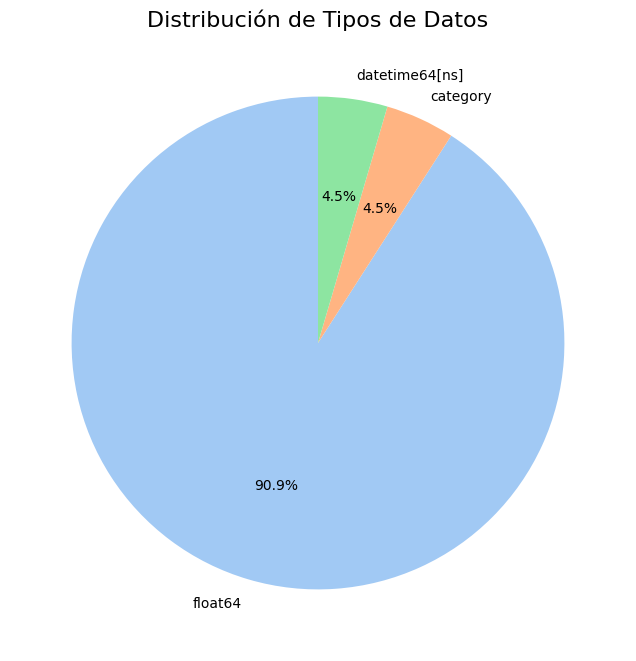

...............···············~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ Descripción Estadística del dataframe ≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~···············............... 


Grupo    grupo              periodo  \
count       72                   72   
unique       8                  NaN   
top     0-15_F                  NaN   
freq         9                  NaN   
mean       NaN  2024-03-01 08:00:00   
min        NaN  2023-03-01 00:00:00   
25%        NaN  2023-09-01 00:00:00   
50%        NaN  2024-03-01 00:00:00   
75%        NaN  2024-09-01 00:00:00   
max        NaN  2025-03-01 00:00:00   
std        NaN                  NaN   

Grupo   Anorexia, bulimia y otros trastornos alimentarios  \
count                                           72.000000   
unique                                                NaN   
top                                                   NaN   
freq                                                  NaN   
mean                                             1.069444  

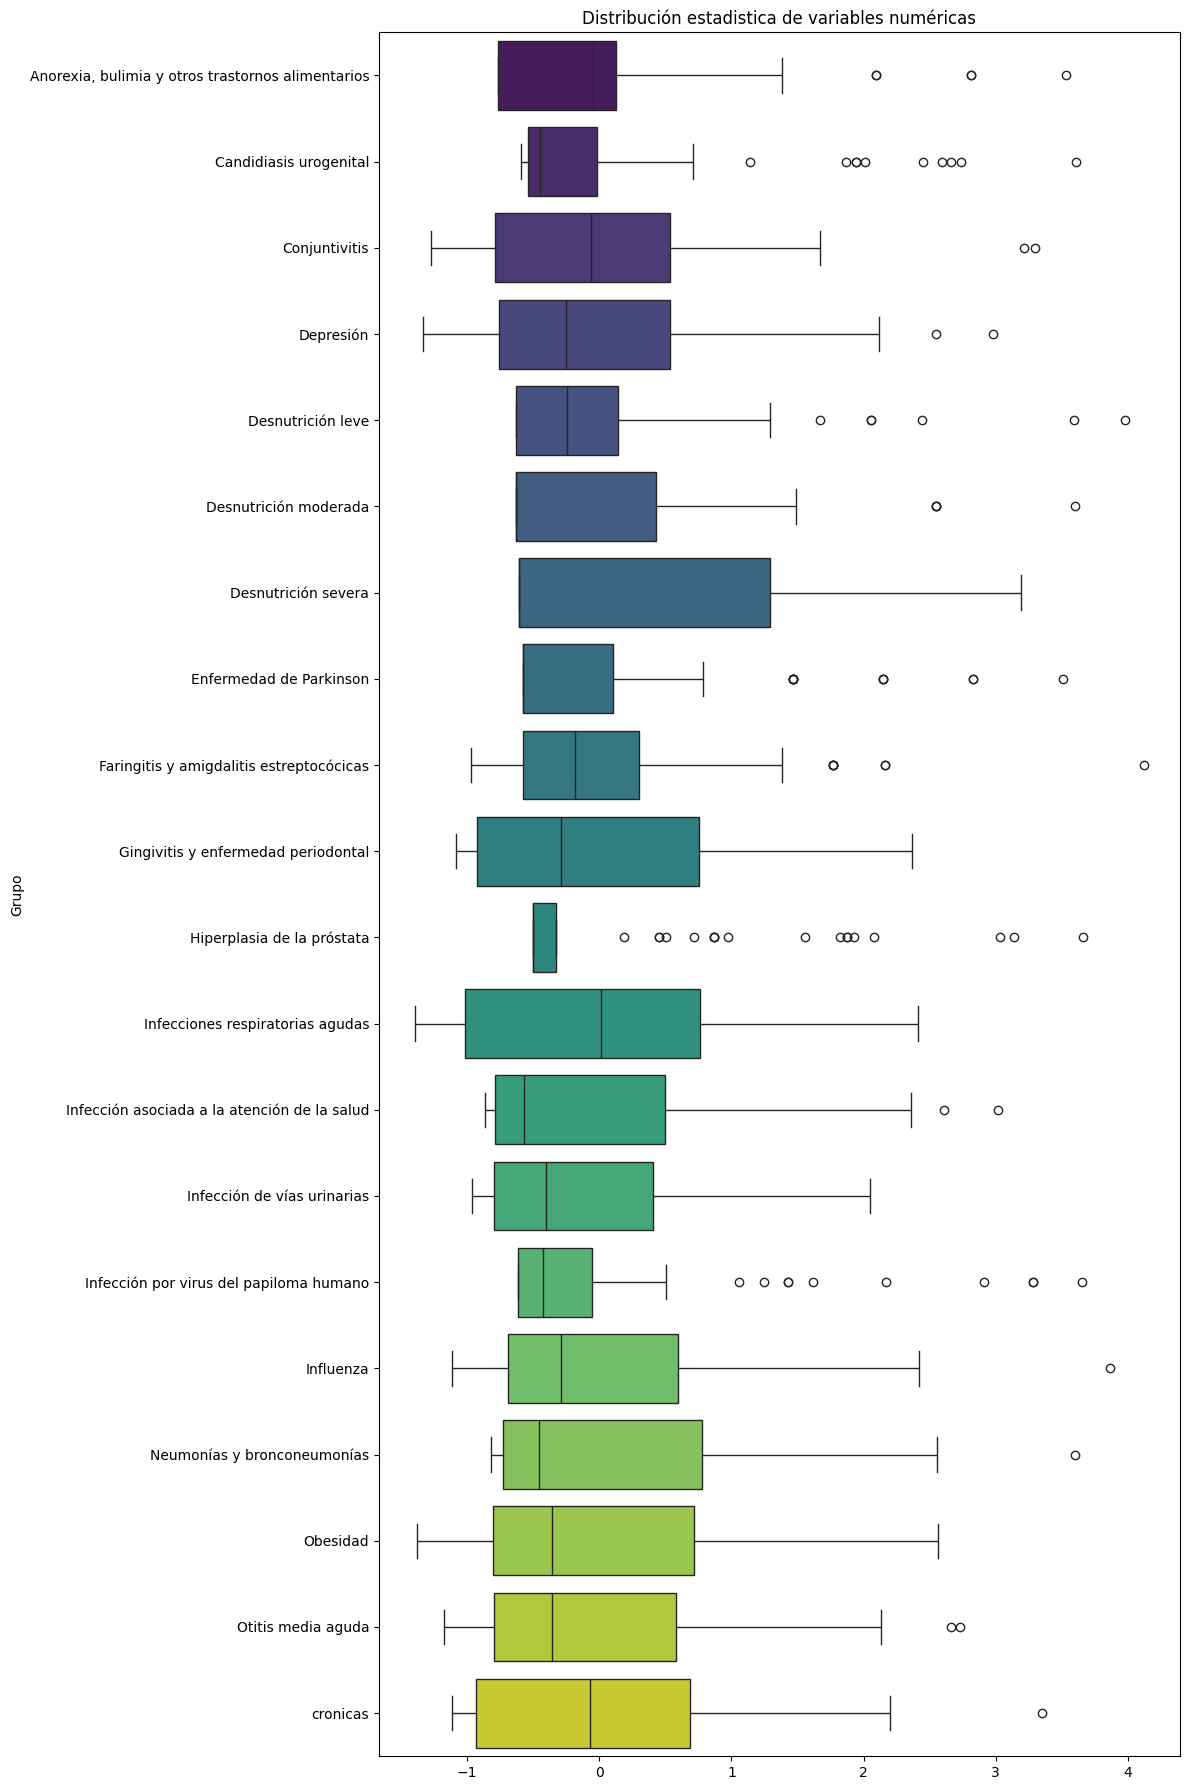

...............···············~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ Normalización de Nombres de Columnas ≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~···············............... 


Se cambia a minúsculas los nombres de las columnas
Nuevos nombres
: Index(['grupo', 'periodo', 'anorexia_bulimia_y_otros_trastornos_alimentarios',
       'candidiasis_urogenital', 'conjuntivitis', 'depresion',
       'desnutricion_leve', 'desnutricion_moderada', 'desnutricion_severa',
       'enfermedad_de_parkinson', 'faringitis_y_amigdalitis_estreptococicas',
       'gingivitis_y_enfermedad_periodontal', 'hiperplasia_de_la_prostata',
       'infecciones_respiratorias_agudas',
       'infeccion_asociada_a_la_atencion_de_la_salud',
       'infeccion_de_vias_urinarias',
       'infeccion_por_virus_del_papiloma_humano', 'influenza',
       'neumonias_y_bronconeumonias', 'obesidad', 'otitis_media_aguda',
       'cronicas'],
      dtype='object')
................················~~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ Corrección de 

Columna  Límite Inferior  \
2   anorexia_bulimia_y_otros_trastornos_alimentarios            -1.88   
3                             candidiasis_urogenital           -10.12   
4                                      conjuntivitis          -329.75   
5                                          depresion            -9.50   
6                                  desnutricion_leve            -3.00   
7                              desnutricion_moderada            -1.50   
8                                desnutricion_severa            -1.50   
9                            enfermedad_de_parkinson            -1.50   
10          faringitis_y_amigdalitis_estreptococicas            -2.38   
11               gingivitis_y_enfermedad_periodontal          -554.12   
12                        hiperplasia_de_la_prostata            -4.88   
13                  infecciones_respiratorias_agudas         -5015.88   
14      infeccion_asociada_a_la_atencion_de_la_salud           -50.88   
15                       infeccion_de_vias_urinarias         -1576.00   
16           infeccion_por_virus_del_papiloma_humano            -4.50   
17                                         influenza           -77.00   
18                       neumonias_y_bronconeumonias           -95.00   
19                                          obesidad           -95.25   
20                                otitis_media_aguda           -69.50   
21                                          cronicas          -877.25   

    Límite Superior  Número Outliers  Porcentaje (%)  
2              3.12                5            6.94  
3             18.88               10           13.89  
4           1020.25                2            2.78  
5             26.50                2            2.78  
6              5.00                6            8.33  
7              2.50                4            5.56  
8              2.50                0            0.00  
9              2.50               11           15.28  
10             6.62                7            9.72  
11          1242.88                0            0.00  
12             8.12               18           25.00  
13         14949.12                0            0.00  
14            90.12                2            2.78  
15          3196.00                0            0.00  
16             7.50               10           13.89  
17           197.00                1            1.39  
18           169.00                1            1.39  
19           312.75                0            0.00  
20           170.50                2            2.78  
21          1816.75                1            1.39

................················~~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ Histogramas de las columnas ≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~~················................ 




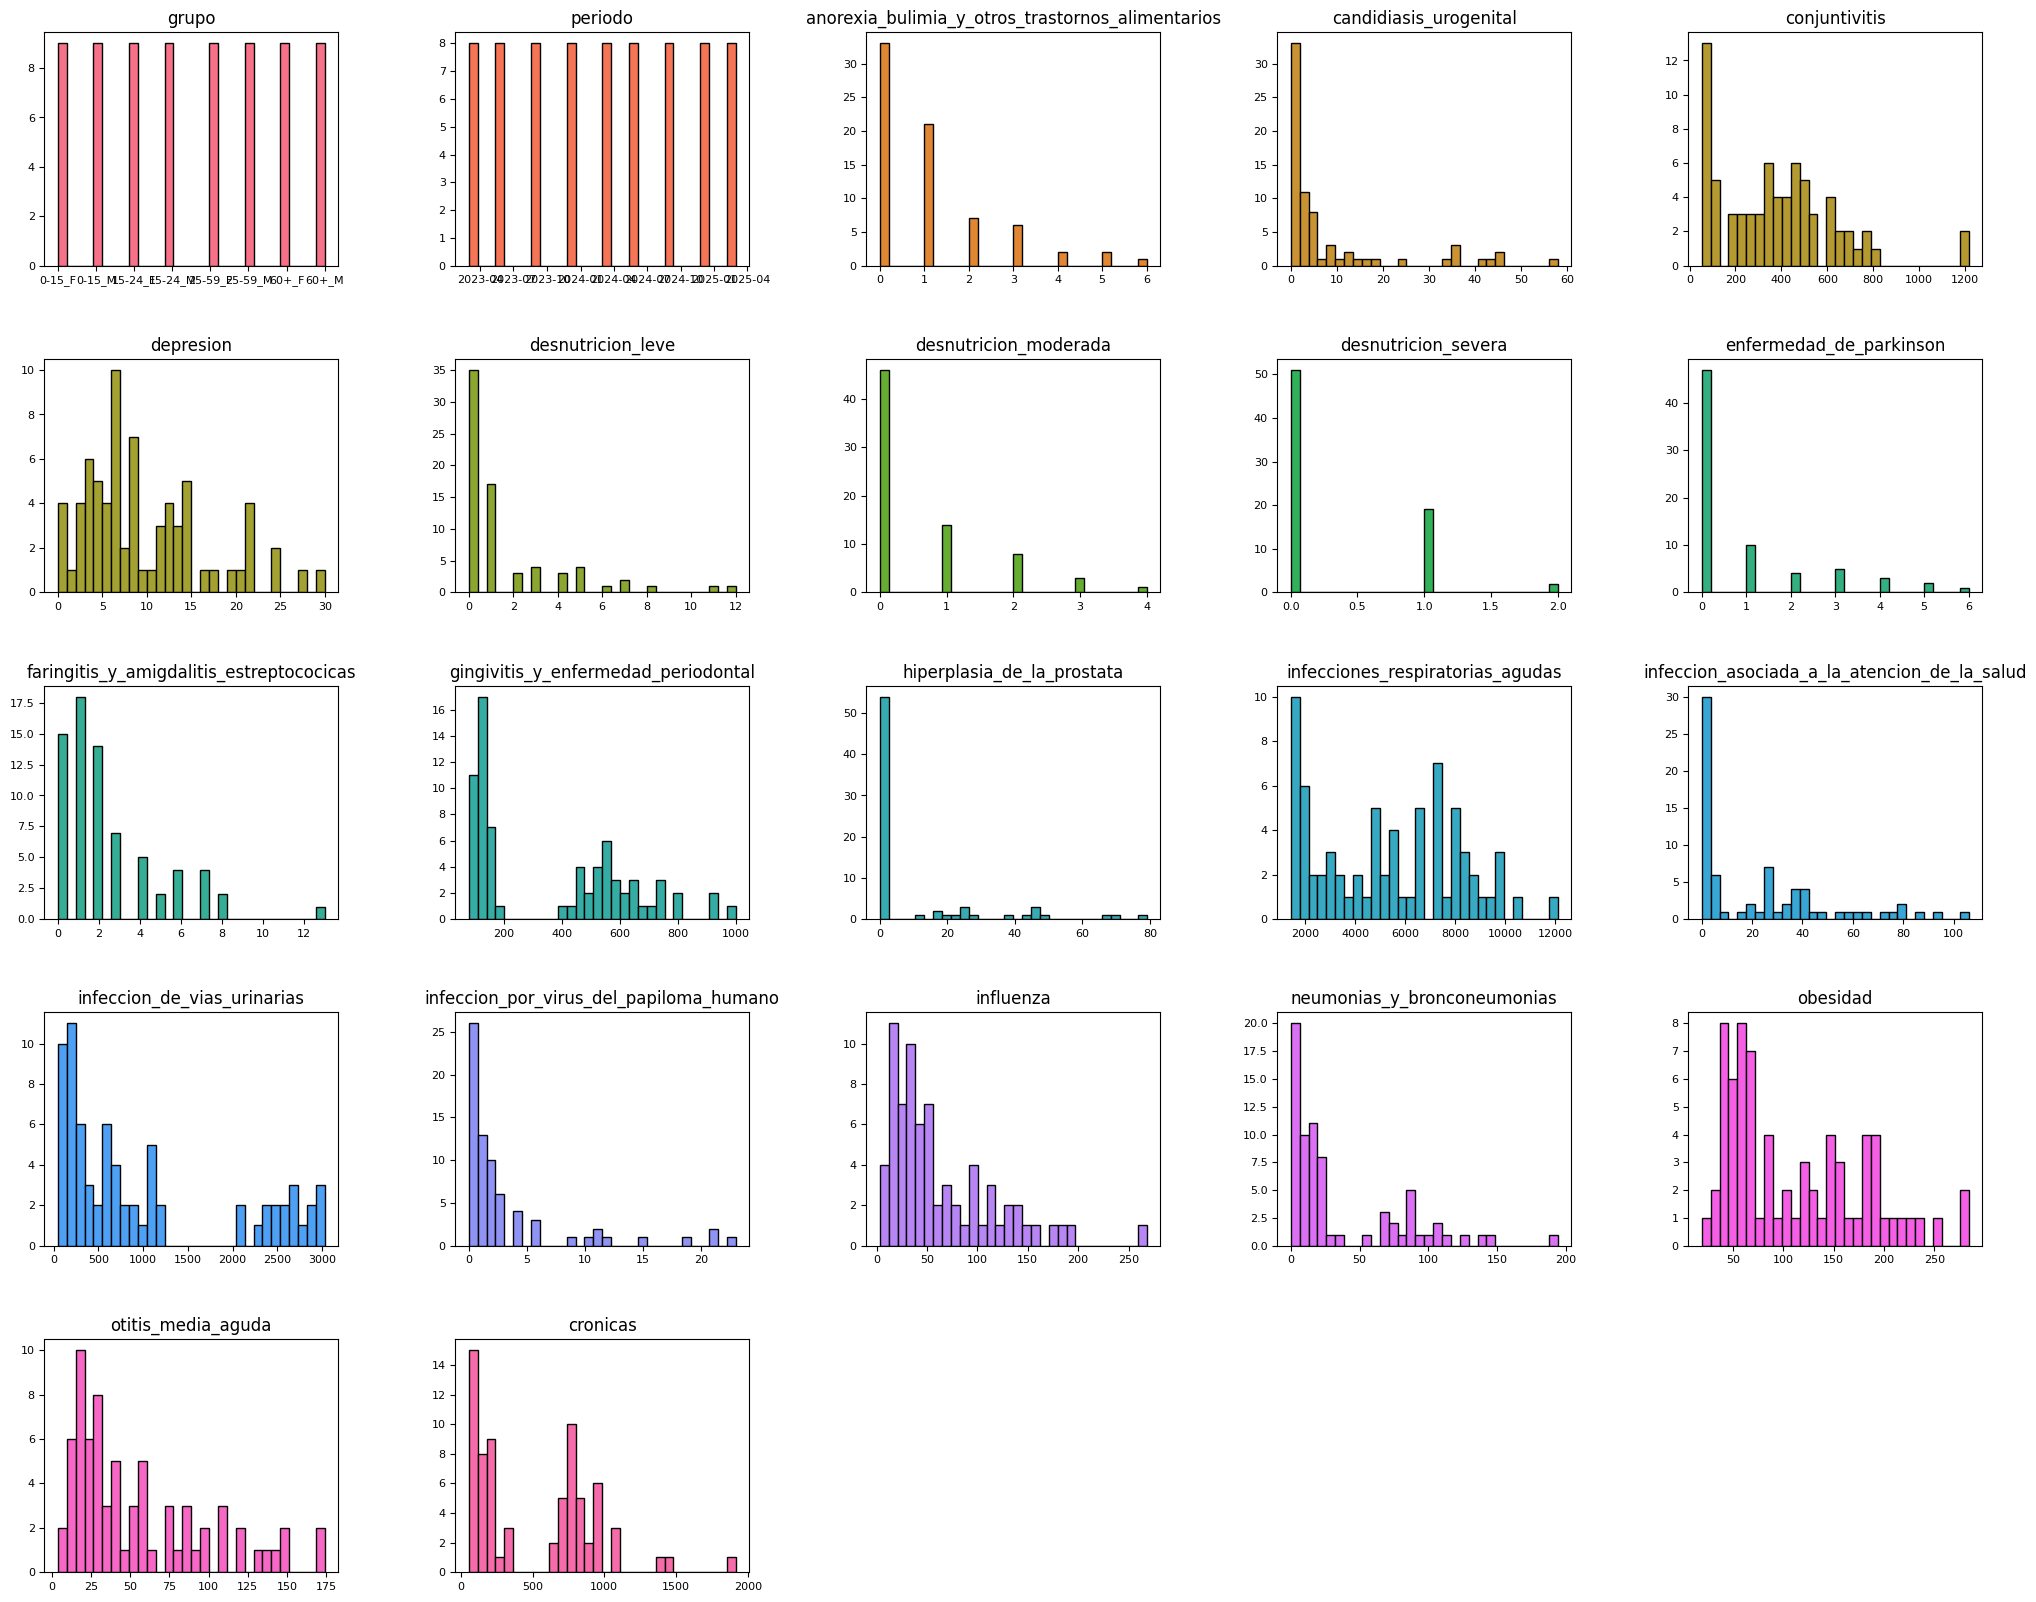

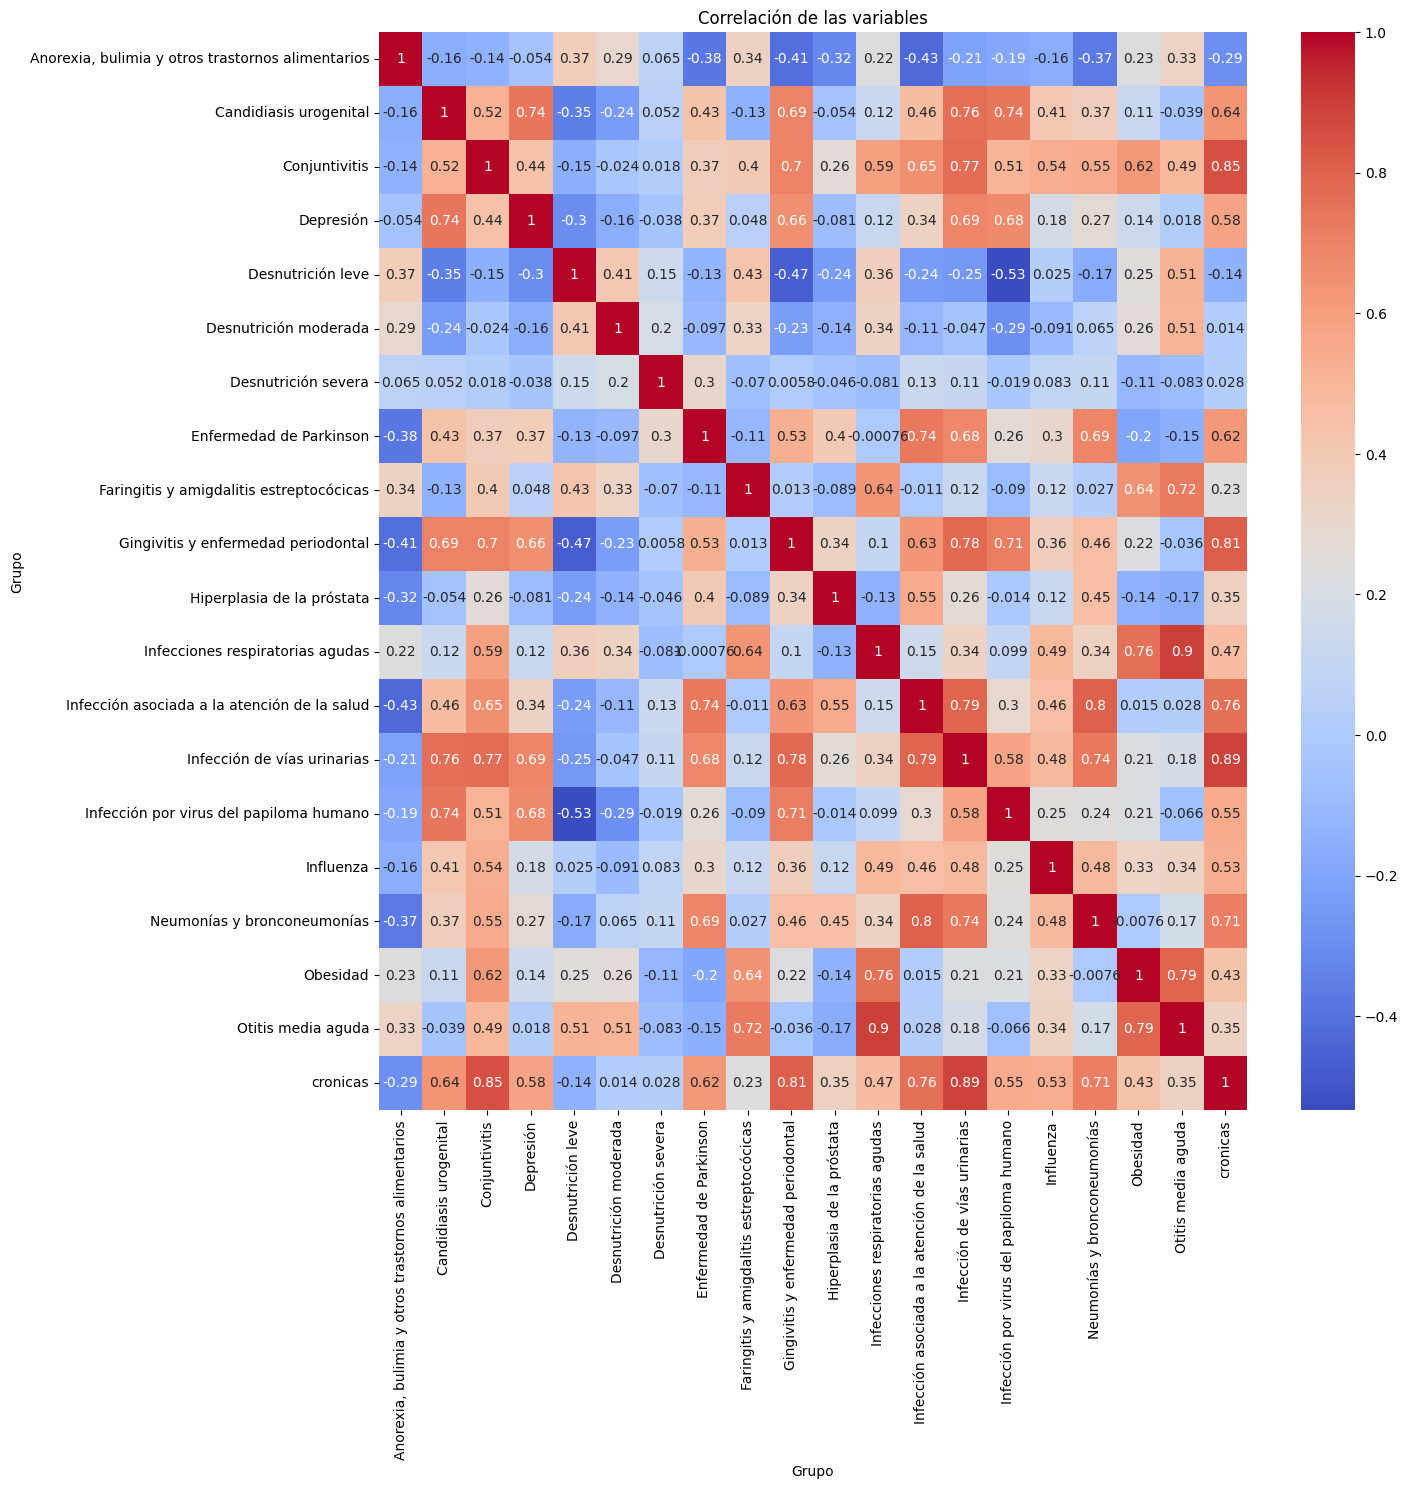

................················~~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ Distribución de las columnas ≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~~················................ 




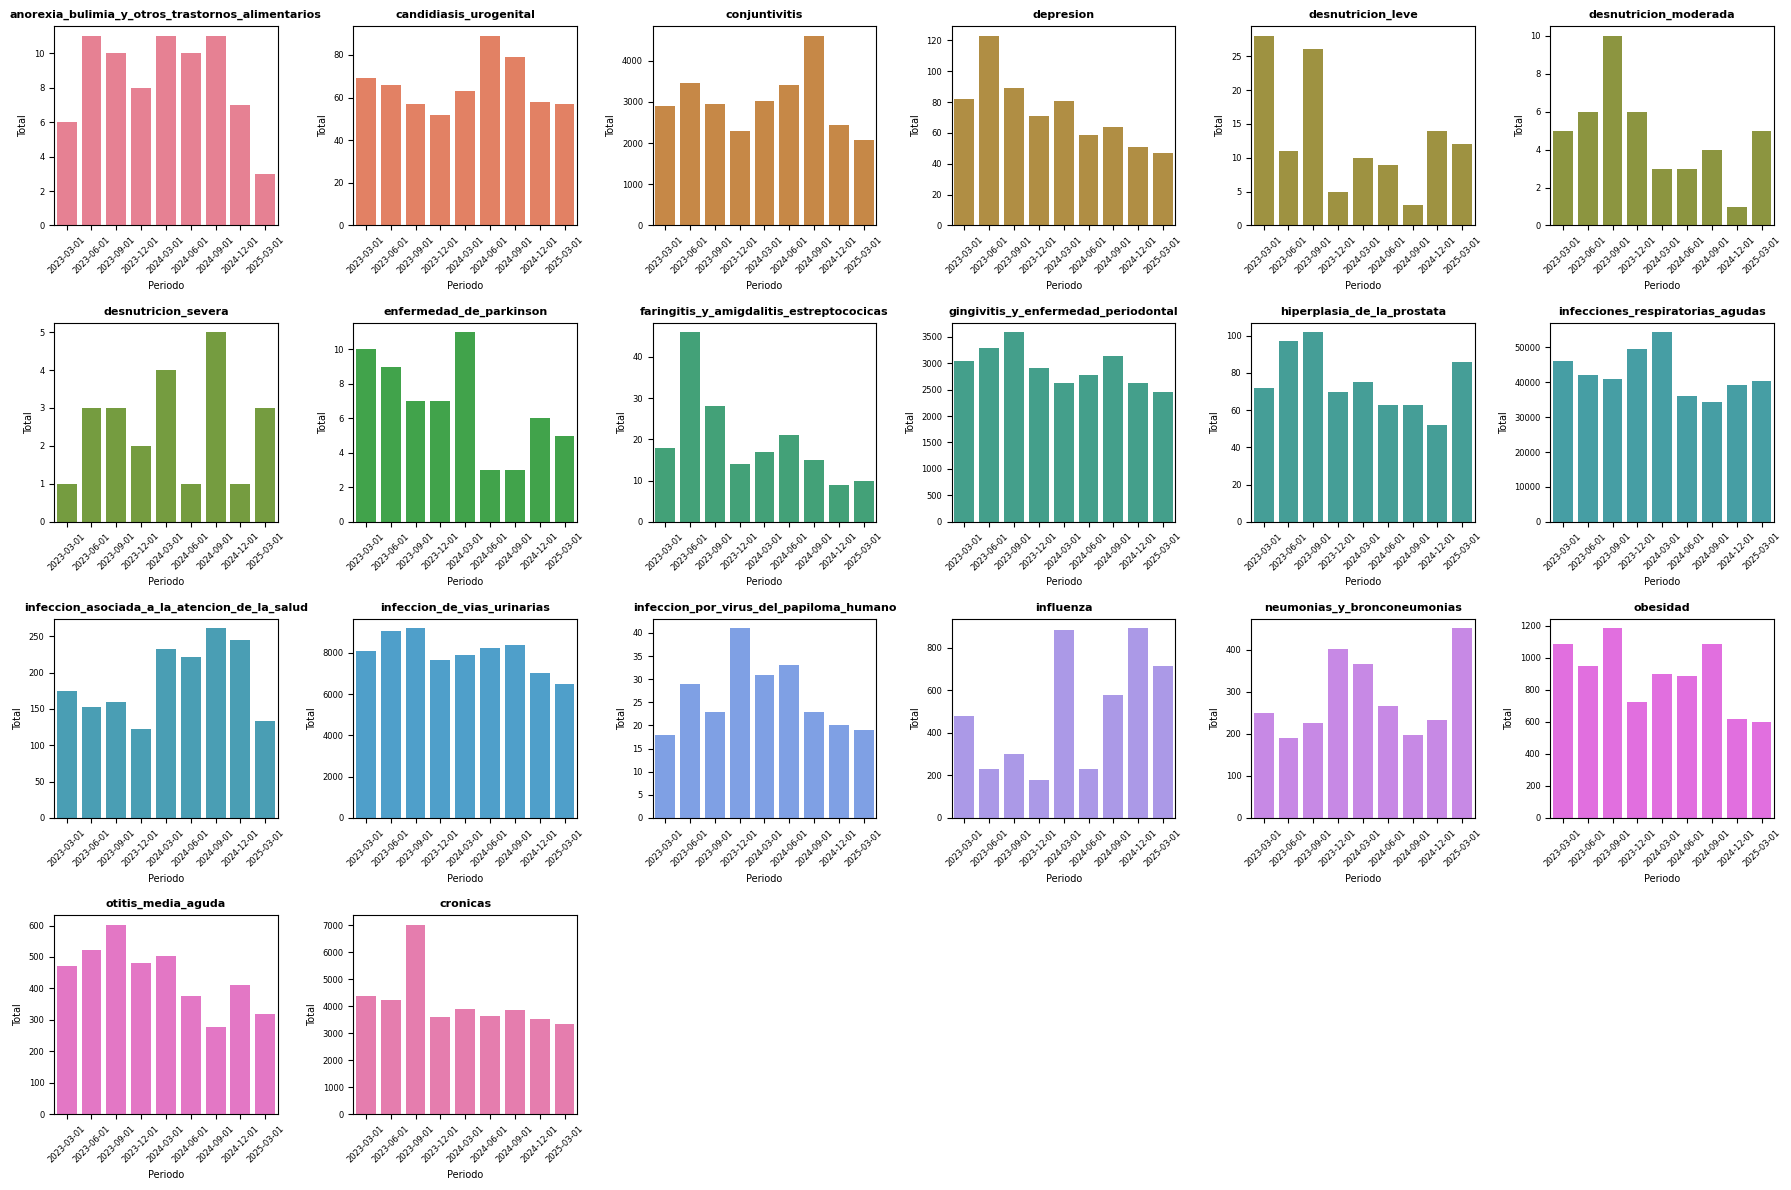

In [ ]:
header('Filas y Columnas')#=================================================================================================
#se separa Grupo del index
df.reset_index(inplace=True)
df.index.name = None

#se cambia grupo a categorica
df.rename(columns={'index':'grupo'}, inplace=True)

df['grupo']=df['grupo'].astype('category')

print(f'La base de datos consta de {df.shape[0]} filas y {df.shape[1]} columnas\n')
header('Nombre de las columnas y su tipo de dato')
tipos=pd.DataFrame({'Tipo':df.dtypes})
tipos.reset_index(inplace=True)
tipos.columns=['Nombre de la columna', 'Tipo']
print(tipos)
plt.figure(figsize=(8,8))
color=sns.color_palette('pastel')
df.dtypes.value_counts().plot(kind='pie', autopct='%1.1f%%', colors=color,startangle=90)
plt.title('Distribución de Tipos de Datos', size=16)
plt.ylabel('') #para que no salga etiqueta en el eje y
plt.show()


header(f'Descripción Estadística del dataframe')#============================================================================
print(df.describe(include='all'))
dfnum=df.select_dtypes(include=[np.number])#===========DFNUM
plt.figure(figsize=(12,18))
dfscal=(dfnum-dfnum.mean())/dfnum.std()
sns.boxplot(data=dfscal, orient='h', palette='viridis')
plt.title('Distribución estadistica de variables numéricas')
plt.tight_layout()
plt.show()


header('Normalización de Nombres de Columnas')#=============================================================================
df.columns = df.columns.str.lower()
#Caractéres especiales
from unidecode import unidecode
#Funcion para quitar las letras con acento, caractéres especiales y sustituir los espacios por "_"
def limpiar_nombres_columnas(df):
    # Convertir a minúsculas, quitar acentos y reemplazar espacios/caracteres especiales
    df.columns = [unidecode(col.lower()).replace(' ', '_').replace(',', '_').replace('-', '_')
                  for col in df.columns]
    # Limpiar múltiples guiones bajos consecutivos
    df.columns = [col.replace('__', '_').strip('_') for col in df.columns]
    return df
df = limpiar_nombres_columnas(df)
print(f'Se cambia a minúsculas los nombres de las columnas\nNuevos nombres\n: {df.columns}')

header('Corrección de tipos de datos')

verificar=True #pequeño bucle para verificar que todos los datos quedaran en float o int
for i in df.columns:
  if not pd.api.types.is_numeric_dtype(df[i]):
    verificar=False
    break
if verificar:
  print('\nTodas las columnas son int o float ✓\n\n')
else:
  print('No todas las columnas son int o float X')


header('Limpieza, Transformación y Normalización de Datos Categóricos')#======================================================
verificar=True
for i in df.columns:
  if not pd.api.types.is_categorical_dtype(df[i]):
    verificar=False
    break
if verificar:
  print('Hay columnas con Datos Categóricos')
else:
  print('\nNo hay columnas con Datos Categóricos\n\n')


header('Datos Perdidos')#======================================================================================================
conteo=df.isna().sum()

#porcentaje de datos perdidos por columna:
if conteo.sum()==0:
  print('\n\nNo hay Datos Perdidos\n\n')
else:
  print(f'SE ENCONTRARON: {df.isna().sum()/df.shape[0]*100}% de datos perdidos')
#Dataframe que muestra el porcentaje de los datos perdidos
if conteo.sum()!=0:
  perdidos=pd.DataFrame({'Cantidad':df.isna().sum(), 'Porcentaje':(df.isna().sum()/df.shape[0])*100})
  print(perdidos[perdidos['Cantidad']>0].sort_values('Cantidad', ascending=False))


header('Limpieza, Transformación y Normalización de Datos Temporales:')#========================================================
#bucle para verificar si tiene datos temporales:
verificar=True
for i in df.columns:
  if not pd.api.types.is_datetime64_dtype(df[i]):
    verificar=False
    break
if verificar:
  print('Hay columnas con Datos Temporales')
else:
  print('\nNo hay columnas con datos temporales\n\n')


header('Outliers')#==============================================================================================================
def analizar_outliers(df):
    # Crear un DataFrame vacío para almacenar los resultados
    resultados = pd.DataFrame(columns=['Columna', 'Límite Inferior', 'Límite Superior',
                                      'Número Outliers', 'Porcentaje (%)'])

    for i, columna in enumerate(df.columns):
      #seleccionar solo los numéricos
        if pd.api.types.is_numeric_dtype(df[columna]):
          Q1 = df[columna].quantile(0.25)
          Q3 = df[columna].quantile(0.75)
          IQR = Q3 - Q1
          limbajo = Q1 - 1.5 * IQR#límites
          limalto = Q3 + 1.5 * IQR

          outliers = df[(df[columna] < limbajo) | (df[columna] > limalto)]#se cuentan los outliers
          num_outliers = len(outliers)
          porcentaje = (num_outliers / len(df)) * 100

          resultados.loc[i] = [columna, round(limbajo, 2), round(limalto, 2),
                            num_outliers, round(porcentaje, 2)]
    return resultados

tabla_outliers = analizar_outliers(df)
display(tabla_outliers)


header('Histogramas de las columnas')#=============================================================================================
from sklearn.preprocessing import StandardScaler

columnas=df.columns.tolist()
gridcol=5
gridfil=math.ceil(len(columnas)/gridcol)
colores = sns.color_palette("husl", len(columnas))
fig = plt.figure(figsize=(5*gridcol, 4*gridfil))
gs = gridspec.GridSpec(gridfil, gridcol, figure=fig, hspace=0.4, wspace=0.4)
for i, col in enumerate(columnas):
    ax = fig.add_subplot(gs[i])
    ax.hist(df[col].dropna(), bins=30, edgecolor='black', color=colores[i])#aqui se cambia
    ax.set_title(col)
    ax.tick_params(axis='both', labelsize=8)
plt.show()

#Correlación Spearman:
plt.figure(figsize=(14,14))
sns.heatmap(dfnum.corr(method='spearman'), cmap='coolwarm', annot=True)
plt.title('Correlación de las variables')
plt.show()

#se grafica con barras en seaborn:
header('Distribución de las columnas')#============================================================================================
# Parámetros del grid
# Excluir columnas de tipo datetime del análisis
columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
n_cols   = 6
n_plots  = len(columnas_numericas)
n_rows   = int(np.ceil(n_plots / n_cols))
colores  = sns.color_palette("husl", n_plots)

# Crear figura y ejes
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(n_cols * 3, n_rows * 3),
                         squeeze=False)

#df['año'] = pd.to_datetime(df['año'])
# Iterar sobre cada columna numérica con su índice
for i, (ax, col) in enumerate(zip(axes.flatten(), columnas_numericas)):
    # Extraer el año de la columna datetime y agrupar
    valores_por_año = df.groupby('periodo')[col].sum()

    sns.barplot(
        x=valores_por_año.index.astype(str),
        y=valores_por_año.values,
        ax=ax,
        color=colores[i])

    ax.set_title(col, fontsize=8, weight='bold')
    ax.set_ylabel('Total', fontsize=7)
    ax.set_xlabel('Periodo', fontsize=7)
    ax.tick_params(axis='x', labelsize=6, rotation=45)
    ax.tick_params(axis='y', labelsize=6)

# Ocultar ejes sobrantes si hay alguno vacío
for ax in axes.flatten()[n_plots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

df.to_csv('/content/drive/MyDrive/PDS/pemex_trimestres.csv', index=False)

## Desgregación de 2016-2022 a trimestrales


     grupo    periodo    cronicas
0   0-15_F 2016-03-01  384.009745
1   0-15_F 2016-06-01  151.590156
2   0-15_F 2016-09-01  218.022484
3   0-15_F 2016-12-01  188.372743
4   0-15_M 2016-03-01  478.120787
5   0-15_M 2016-06-01  193.017469
6   0-15_M 2016-09-01  228.355911
7   0-15_M 2016-12-01  241.445439
8  15-24_F 2016-03-01  277.143109
9  15-24_F 2016-06-01  134.567873
       grupo    periodo  cronicas
286   0-15_F 2024-12-01     169.0
287  15-24_M 2024-12-01      65.0
288    60+_F 2025-03-01     743.0
289   0-15_F 2025-03-01     146.0
290   0-15_M 2025-03-01     168.0
291  15-24_F 2025-03-01      67.0
292  15-24_M 2025-03-01      64.0
293  25-59_F 2025-03-01     799.0
294  25-59_M 2025-03-01     684.0
295    60+_M 2025-03-01     679.0
periodo
2016-03-01    8
2016-06-01    8
2016-09-01    8
2016-12-01    8
2017-03-01    8
2017-06-01    8
2017-09-01    8
2017-12-01    8
2018-03-01    8
2018-06-01    8
2018-09-01    8
2018-12-01    8
2019-03-01    8
2019-06-01    8
2019-09-01    8
2019

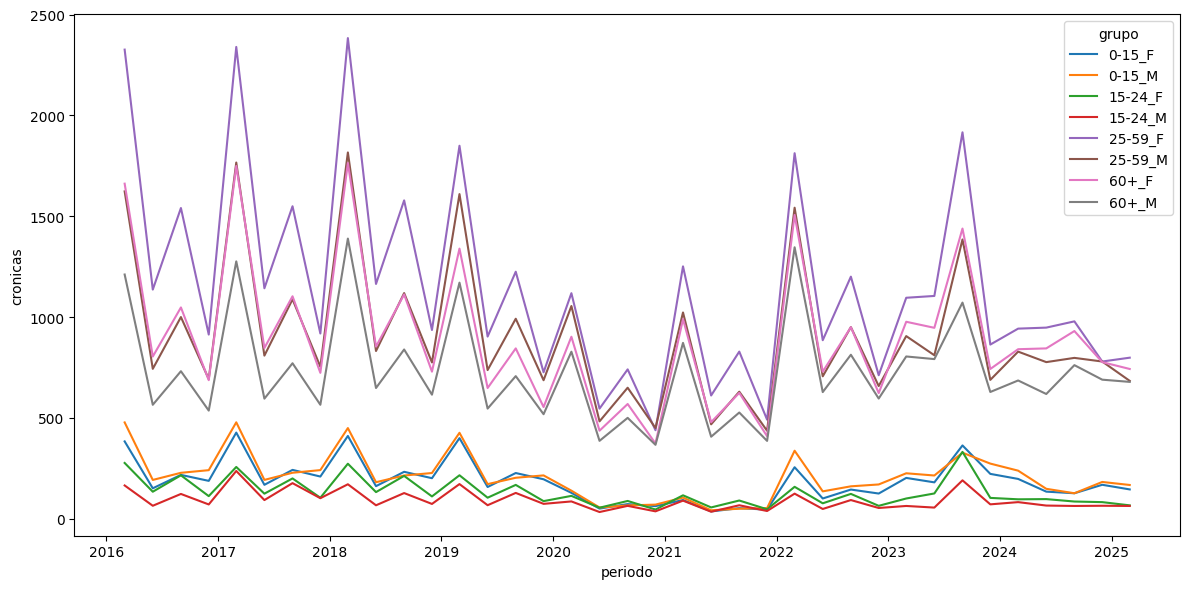

In [ ]:

df_ann = pd.read_csv('/content/drive/MyDrive/PDS/pemex_prophet_all.csv', parse_dates=['periodo'])
df_qr = pd.read_csv('/content/drive/MyDrive/PDS/pemex_trimestres.csv', parse_dates=['periodo'])

# Calcula factores estacionales de df_qr
#df_tmp = df_qr.copy()
df_tmp=df_qr.copy()
df_tmp['year']    = df_tmp['periodo'].dt.year
df_tmp['quarter'] = df_tmp['periodo'].dt.quarter

# Suma anual real
annual_sum = (df_tmp
    .groupby(['grupo','year'])['cronicas']
    .sum()
    .rename('annual_sum')
    .reset_index())

# Concatena y fracción trimestral
df_tmp = df_tmp.merge(annual_sum, on=['grupo','year'])
df_tmp['q_frac'] = df_tmp['cronicas'] / df_tmp['annual_sum']

# Promedia por grupo y trimestre
seasonal_factors = (df_tmp
    .groupby(['grupo','quarter'])['q_frac']
    .mean()
    .unstack(level='quarter')
    .fillna(1/4))   # si faltase algún trimestre

# Desagrega df_ann 2016–2022 usando esos factores
records = []
for _, row in df_ann.iterrows():
    grp   = row['grupo']
    year  = row['periodo'].year
    total = row['cronicas']
    # si el grupo no está en seasonal_factors, asumimos 1/4 a cada trimestre
    if grp in seasonal_factors.index:
        factors = seasonal_factors.loc[grp]
    else:
        factors = pd.Series([0.25]*4, index=[1,2,3,4])
    for q, frac in factors.items():
        records.append({
            'grupo'  : grp,
            'periodo': pd.Timestamp(f"{year}-{3*q:02d}-01"),
            'cronicas': total * frac})

df_est = pd.DataFrame(records)# es el df con todos los datos anuales fragmentados a trimestrales, del 2016 al 2022
df_qr_sel=df_qr[['grupo', 'periodo', 'cronicas']] #es el df trimestral en donde solo se seleccionan las 3 columnas de interés
df_qr_sel.sort_values('periodo', inplace=True)
df_total = pd.concat([df_est, df_qr_sel], ignore_index=True)
print(df_total.head(10))
print(df_total.tail(10))
print(df_total['periodo'].value_counts())
#df_total.sort_values(['grupo', 'periodo'], inplace=True)

plt.figure(figsize=(12,6))
sns.lineplot(data=df_total, x='periodo', y='cronicas', hue='grupo')
plt.tight_layout()
plt.show()

df_total.to_csv('/content/drive/MyDrive/PDS/pemex_trimestres_all.csv', index=False)

#================================================================================================

# SARIMA =========================================================





## Modelado

In [ ]:

warnings.filterwarnings("ignore")

df = pd.read_csv('/content/drive/MyDrive/PDS/pemex_trimestres_all.csv', parse_dates=['periodo'])

df_indexed = df.set_index('periodo')

#se predicen los grupos, con un bucle
lista_predicciones = []
unique_groups = df['grupo'].unique()

for grupo in unique_groups:
    print(f"Procesando y entrenando para el grupo: {grupo}...")

    # Filtrar la serie de tiempo para el grupo actual
    serie = df_indexed[df_indexed['grupo'] == grupo]['cronicas']
    orden_sarima = (1, 1, 1)
    orden_estacional = (1, 1, 1, 4) # s=4 para datos trimestrales

    # Crear y entrenar el modelo SARIMA
    try:
        modelo = SARIMAX(
            serie,
            order=orden_sarima,
            seasonal_order=orden_estacional,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        resultado = modelo.fit(disp=False)

        # Generar el pronóstico a futuro (2 años = 8 trimestres)
        n_pasos = 8
        pronostico_obj = resultado.get_forecast(steps=n_pasos)

        # Extraer predicción e intervalo de confianza
        prediccion_media = pronostico_obj.predicted_mean
        intervalo_confianza = pronostico_obj.conf_int()

        # Se crea un DataFrame con los resultados y se guarda en la lista
        df_pred = pd.DataFrame({
            'periodo': prediccion_media.index,
            'grupo': grupo,
            'prediccion': prediccion_media,
            'limite_inferior': intervalo_confianza.iloc[:, 0],
            'limite_superior': intervalo_confianza.iloc[:, 1]
        })
        lista_predicciones.append(df_pred)

    except Exception as e:
        print(f"  > Error al procesar el grupo '{grupo}': {e}. Saltando...")
        continue

# Unir todos los pronósticos en un solo DataFrame
df_predicciones = pd.concat(lista_predicciones)

# 1) Preparar histórico
hist = df[['periodo','grupo','cronicas']].rename(columns={'cronicas':'valor'})
hist['tipo'] = 'Histórico'

# 2) Preparar pronóstico y añadir el último histórico
# 2.1) Extraigo último punto por grupo
last_obs = hist.groupby('grupo').last().reset_index()[['periodo','grupo','valor']]

# 2.2) Renombro pronóstico y uno ambos
fc = df_predicciones[['periodo','grupo','prediccion']].rename(columns={'prediccion':'valor'})
# concateno: primero el last_obs, luego las predicciones reales
fc_all = pd.concat([last_obs, fc], ignore_index=True, sort=False)
fc_all['tipo'] = 'Pronóstico'

# 3) Combino todo y ordeno
df_plot = pd.concat([hist, fc_all], ignore_index=True).sort_values(
    ['grupo','periodo']
)

# Se grafica
plt.figure(figsize=(18, 9))
sns.lineplot(
    data=df_plot,
    x='periodo',
    y='valor',
    hue='grupo',
    style='tipo',
    dashes={
      'Histórico' : (),      # línea continua
      'Pronóstico': (4,2)},    # 4pt on, 2pt off
    palette='tab10',
    linewidth=1.5)

# Sombreado de intervalos sobre la misma figura
for g in df_predicciones['grupo'].unique():
    sub = df_predicciones[df_predicciones['grupo']==g]
    plt.fill_between(sub['periodo'],sub['limite_inferior'],sub['limite_superior'],alpha=0.15)

plt.title('Histórico y Pronóstico SARIMA por Grupo Demográfico', pad=20)
plt.xlabel('Periodo')
plt.ylabel('Casos de Enfermedades Crónicas')
plt.legend(title='Grupo / Tipo', bbox_to_anchor=(1.01,1), loc='upper left')
plt.tight_layout()
plt.show()




## Validación

In [ ]:

df = pd.read_csv(
    '/content/drive/MyDrive/PDS/pemex_trimestres_all.csv',
    parse_dates=['periodo']
)
# Usa fin de trimestre
df['periodo'] = (
    pd.to_datetime(df['periodo'])
      .dt.to_period('Q')
      .dt.to_timestamp(how='end')
)
df_indexed = df.set_index('periodo')
unique_groups = df['grupo'].unique()

# — 2. Listas para guardar métricas
metricas_info = []
metricas_prec = []
n_test = 4  # últimos 4 trimestres para test out-of-sample

for grupo in unique_groups:
    serie = df_indexed[df_indexed['grupo'] == grupo]['cronicas']

    # — 2.1 In-sample: ajuste completo
    mod_full = SARIMAX(
        serie,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 4),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res_full = mod_full.fit(disp=False)
    metricas_info.append({
        'grupo': grupo,
        'AIC':  res_full.aic,
        'BIC':  res_full.bic,
        'HQIC': res_full.hqic
    })

    # — 2.2 Out-of-sample: split train/test
    train, test = serie[:-n_test], serie[-n_test:]
    mod_trunc = SARIMAX(
        train,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 4),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res_trunc = mod_trunc.fit(disp=False)

    # Predecir sobre el rango de test
    fc = res_trunc.predict(
        start=test.index[0],
        end=test.index[-1]
    )
    mae  = mean_absolute_error(test, fc)
    rmse = np.sqrt(mean_squared_error(test, fc))
    mape = np.mean(np.abs((test - fc) / test)) * 100

    metricas_prec.append({
        'grupo':     grupo,
        'MAE':       mae,
        'RMSE':      rmse,
        'MAPE (%)':  mape
    })

# — 3. Unir y mostrar resultados
df_info = pd.DataFrame(metricas_info)
df_prec = pd.DataFrame(metricas_prec)
df_eval = df_info.merge(df_prec, on='grupo')

print("\nEvaluación del modelo SARIMA (base):")
print(df_eval.to_string(index=False))


# PROPHET========================================================

## Best Params

In [ ]:
warnings.filterwarnings('ignore')

# 1) Datos
df = pd.read_csv(
    '/content/drive/MyDrive/PDS/pemex_trimestres_all.csv',
    parse_dates=['periodo']
)
df['periodo'] = (
    pd.to_datetime(df['periodo'])
      .dt.to_period('Q')
      .dt.to_timestamp(how='end')
)
df_prop = df.rename(columns={'periodo':'ds','cronicas':'y'})[['ds','grupo','y']]
groups = df_prop['grupo'].unique()

# 2) Función de error porcentual
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100

n_test = 4   # últimos 4 trimestres para validación

# 3) Espacio de búsqueda
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [1.0, 5.0, 10.0],
    'fourier_order':           [3, 5, 10],
    'seasonality_mode':        ['additive', 'multiplicative']
}

best_params = []
# 4) Grid-search por grupo
for grupo in groups:
    df_g   = df_prop[df_prop['grupo']==grupo].reset_index(drop=True)
    train  = df_g.iloc[:-n_test]
    test   = df_g.iloc[-n_test:]
    best_m  = np.inf
    best_cfg = None

    for cps in param_grid['changepoint_prior_scale']:
        for sps in param_grid['seasonality_prior_scale']:
            for fo in param_grid['fourier_order']:
                for mode in param_grid['seasonality_mode']:
                    # configurar y ajustar
                    m = Prophet(
                        seasonality_mode=mode,
                        changepoint_prior_scale=cps,
                        seasonality_prior_scale=sps,
                        yearly_seasonality=False,
                        weekly_seasonality=False,
                        daily_seasonality=False
                    )
                    m.add_seasonality('quarterly', period=91.25, fourier_order=fo)
                    m.fit(train[['ds','y']])

                    # predecir test
                    future = m.make_future_dataframe(periods=n_test, freq='Q')
                    fc     = m.predict(future).set_index('ds')
                    y_true = test['y'].values
                    y_hat  = fc.loc[test['ds'], 'yhat'].values

                    mape = MAPE(y_true, y_hat)
                    if mape < best_m:
                        best_m   = mape
                        best_cfg = (cps, sps, fo, mode)

    best_params.append({
        'grupo':                   grupo,
        'best_cps':                best_cfg[0],
        'best_sps':                best_cfg[1],
        'best_fourier_order':      best_cfg[2],
        'best_seasonality_mode':   best_cfg[3],
        'MAPE(test %)':            round(best_m, 2)
    })

# 5) Mostrar mejores parámetros
df_best = pd.DataFrame(best_params)
print("\nMejores hiperparámetros Prophet por grupo:")
print(df_best.to_string(index=False))


## Modelado y métricas

DEBUG:cmdstanpy:input tempfile: /tmp/tmphkb7l60w/tzpq520w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphkb7l60w/wg645jg4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60417', 'data', 'file=/tmp/tmphkb7l60w/tzpq520w.json', 'init=/tmp/tmphkb7l60w/wg645jg4.json', 'output', 'file=/tmp/tmphkb7l60w/prophet_modelqqey6f14/prophet_model-20250708211042.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:10:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:10:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(
DEBUG:cmdstanpy:input tempfile: /tmp/tmphkb7l60w/


Validación Prophet (mejorado por grupo):
  grupo  MAE(test)  RMSE(test)  MAPE(test)
 0-15_F     15.606      19.290       11.02
 0-15_M     12.800      16.912        8.58
15-24_F     10.017      10.728       11.94
15-24_M     10.014      12.050       15.49
25-59_F    164.389     205.944       17.69
25-59_M     65.317      82.915        8.39
  60+_F    130.136     165.251       14.97
  60+_M     68.203      88.758        9.44


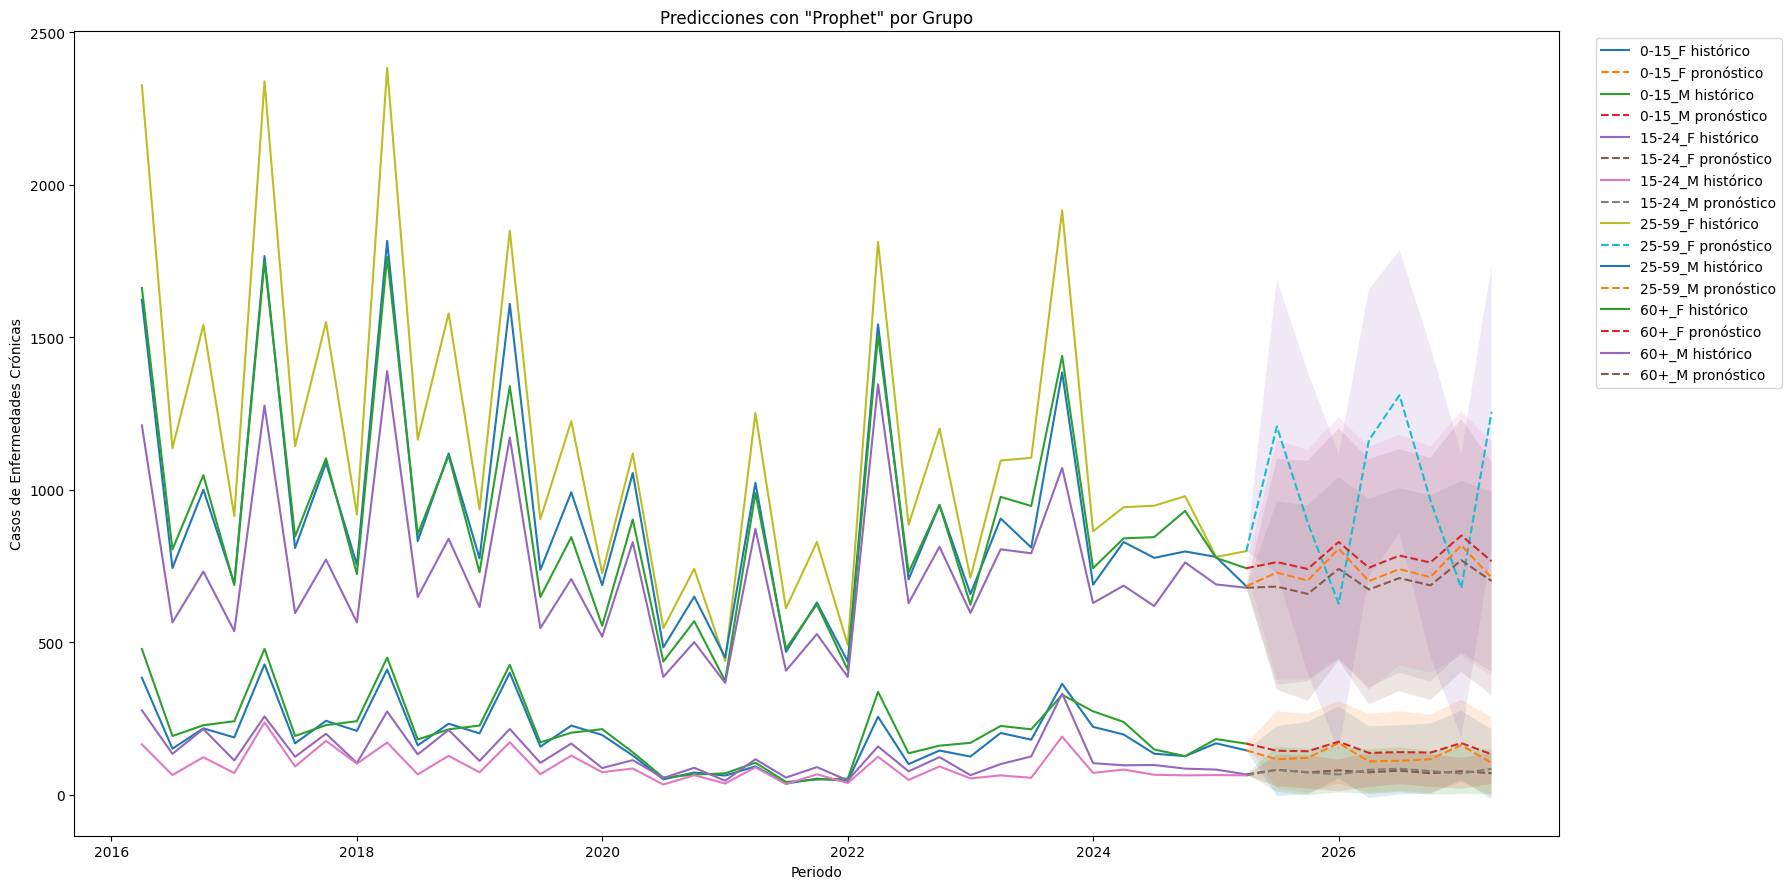

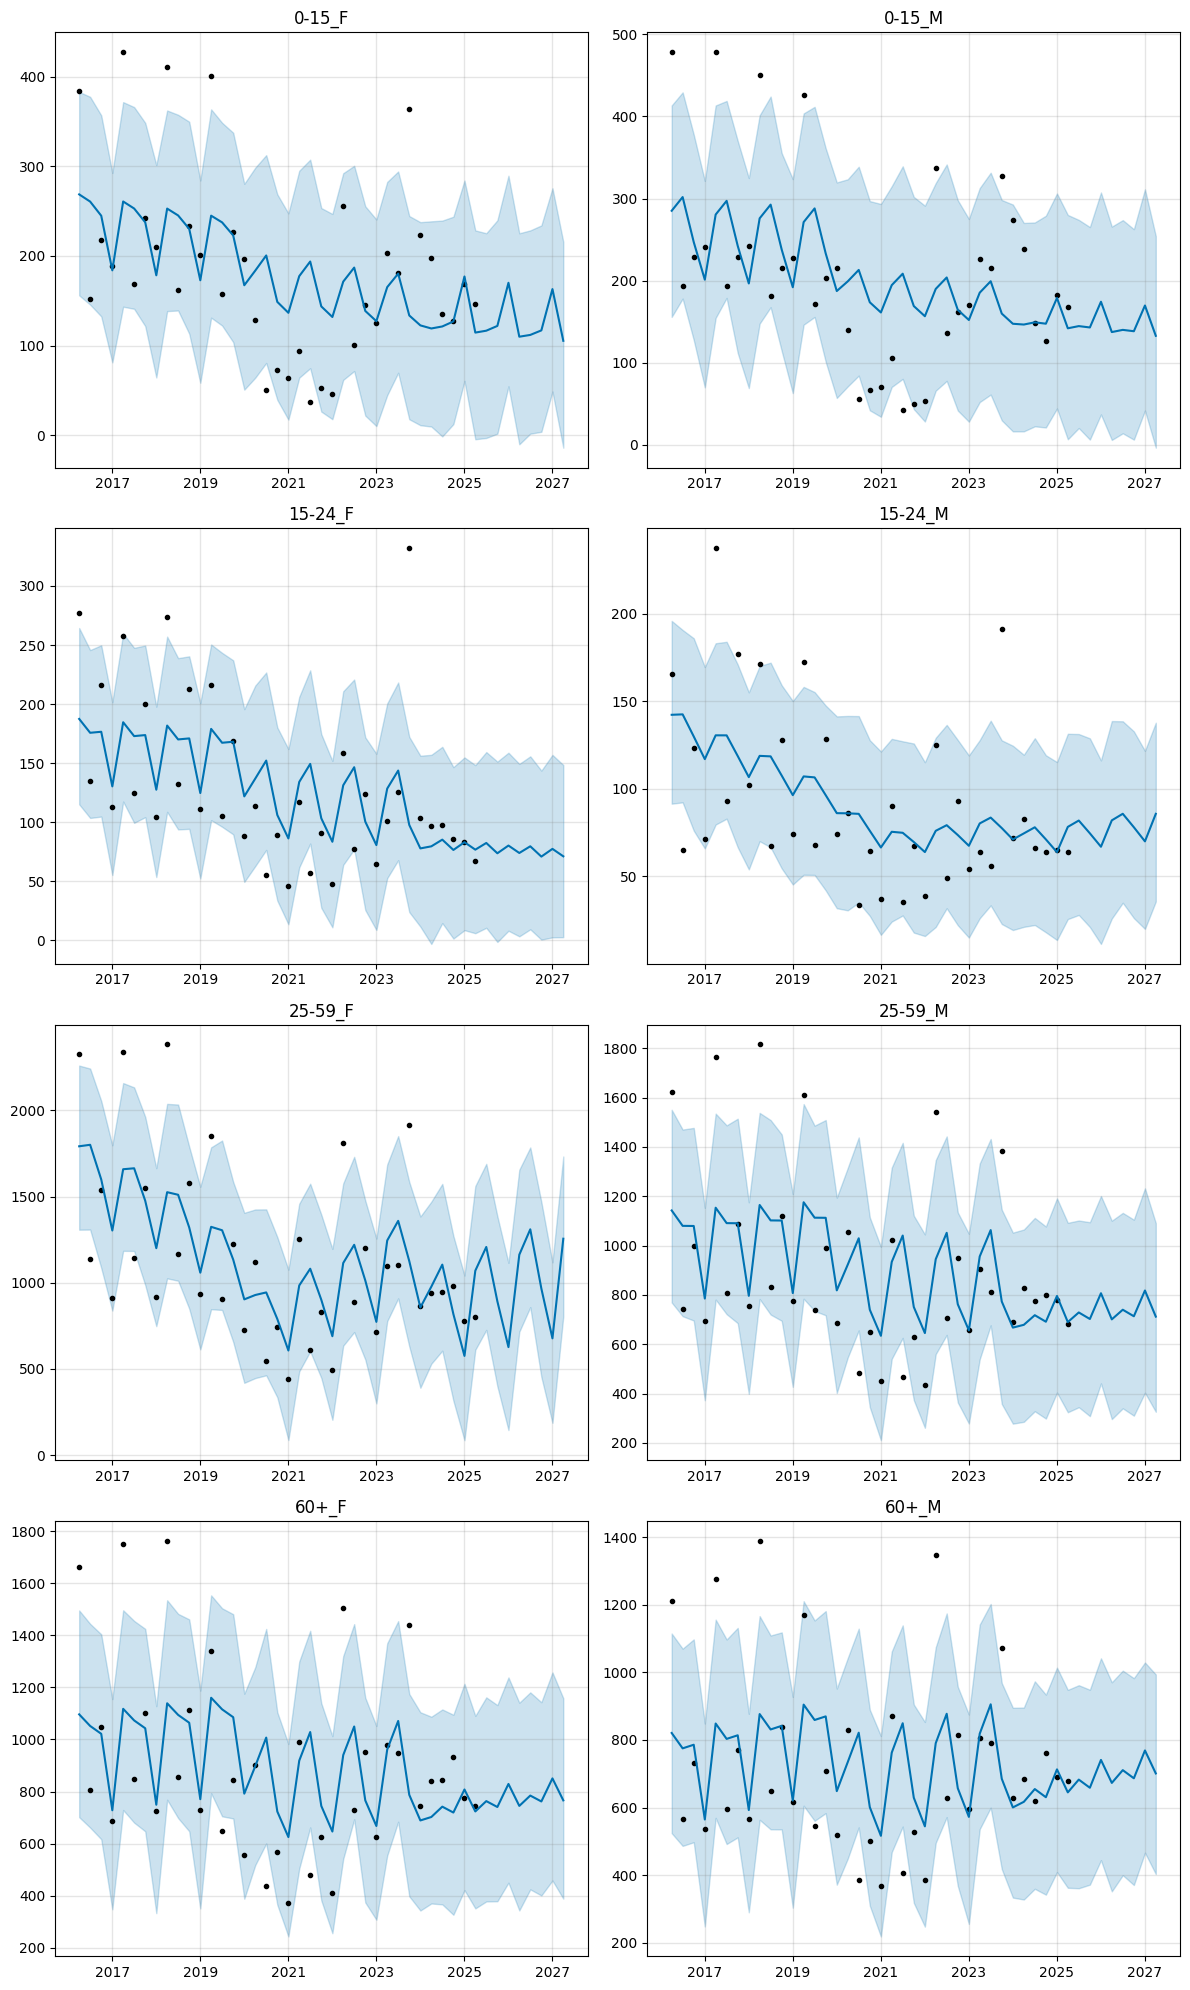

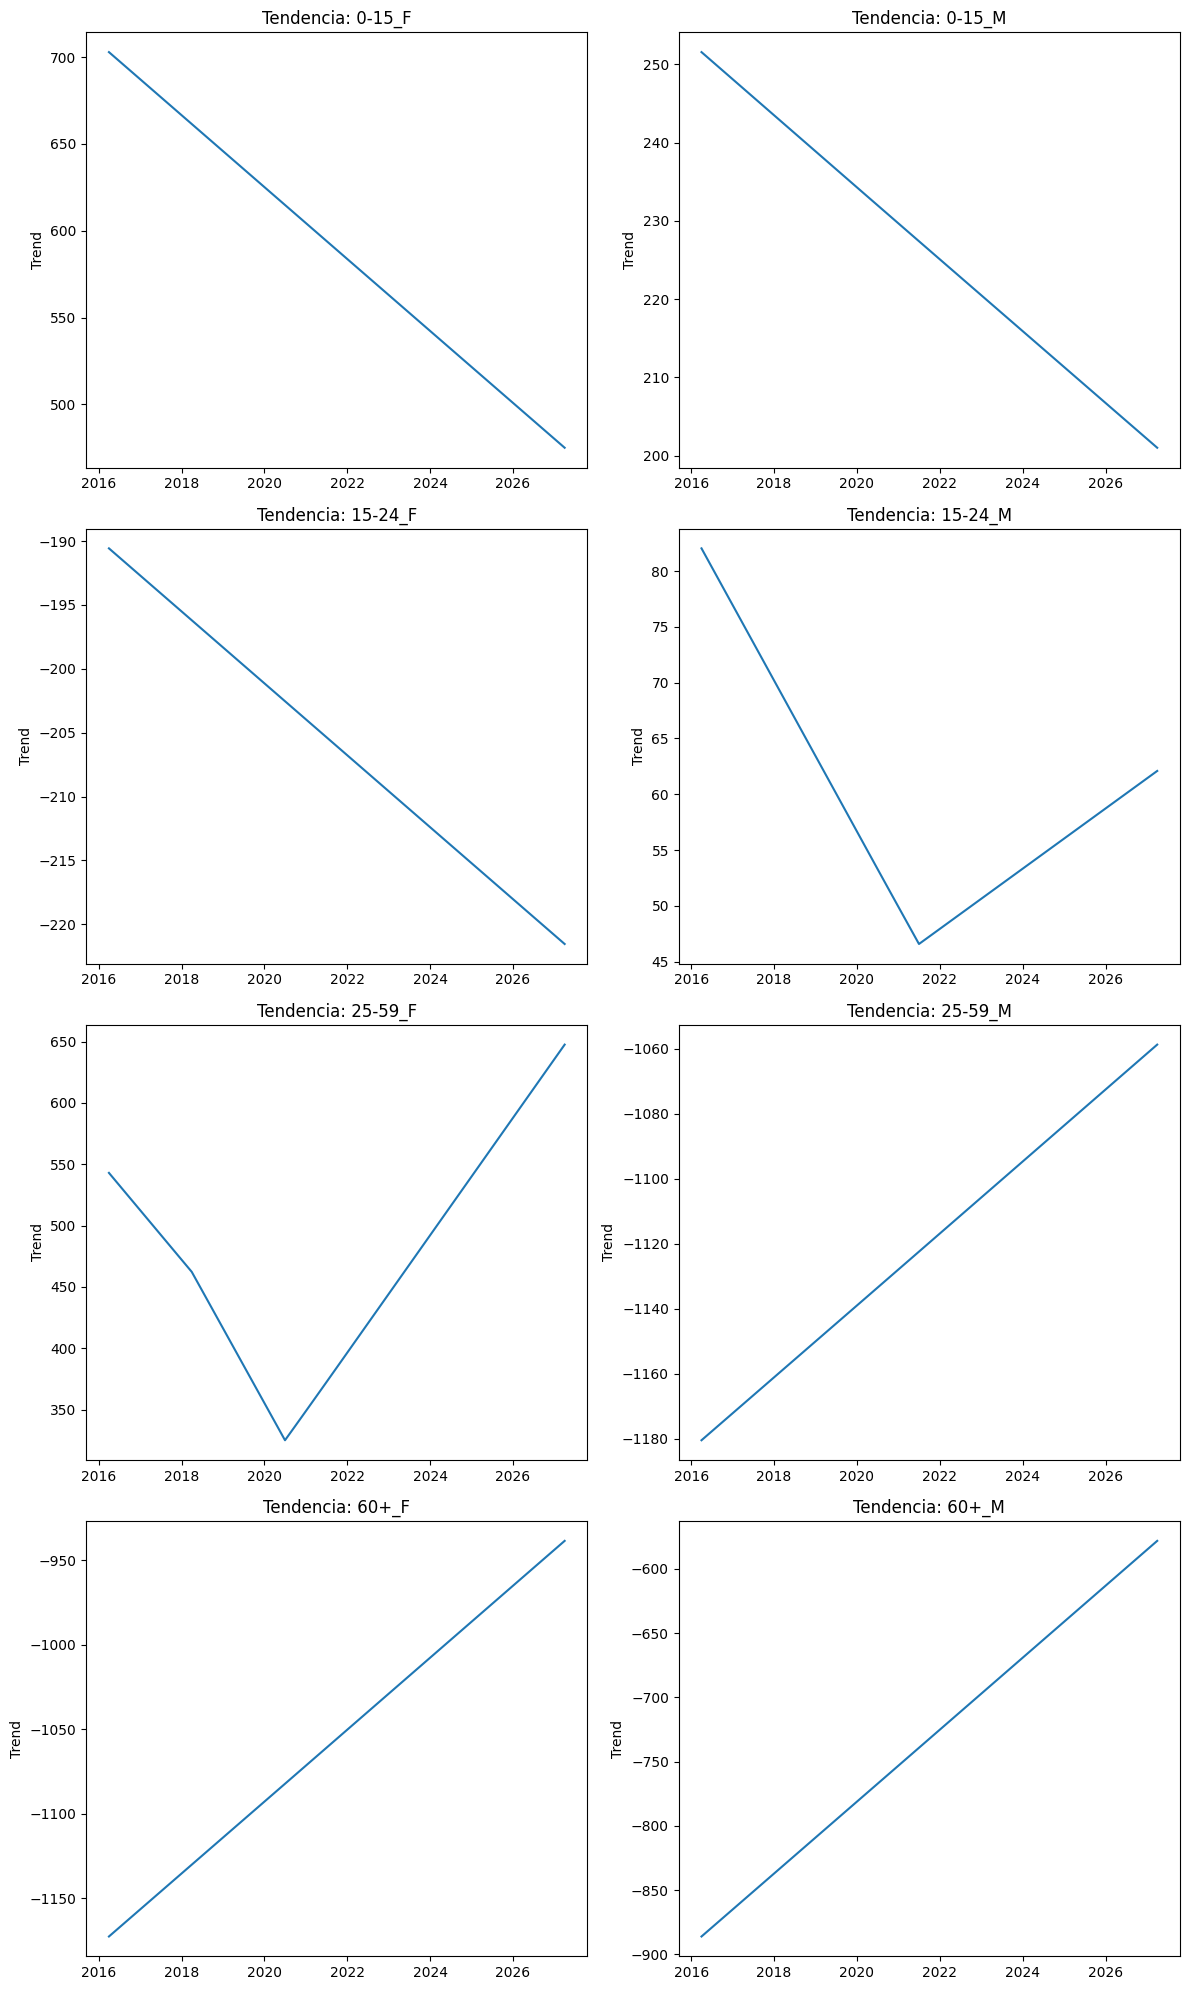

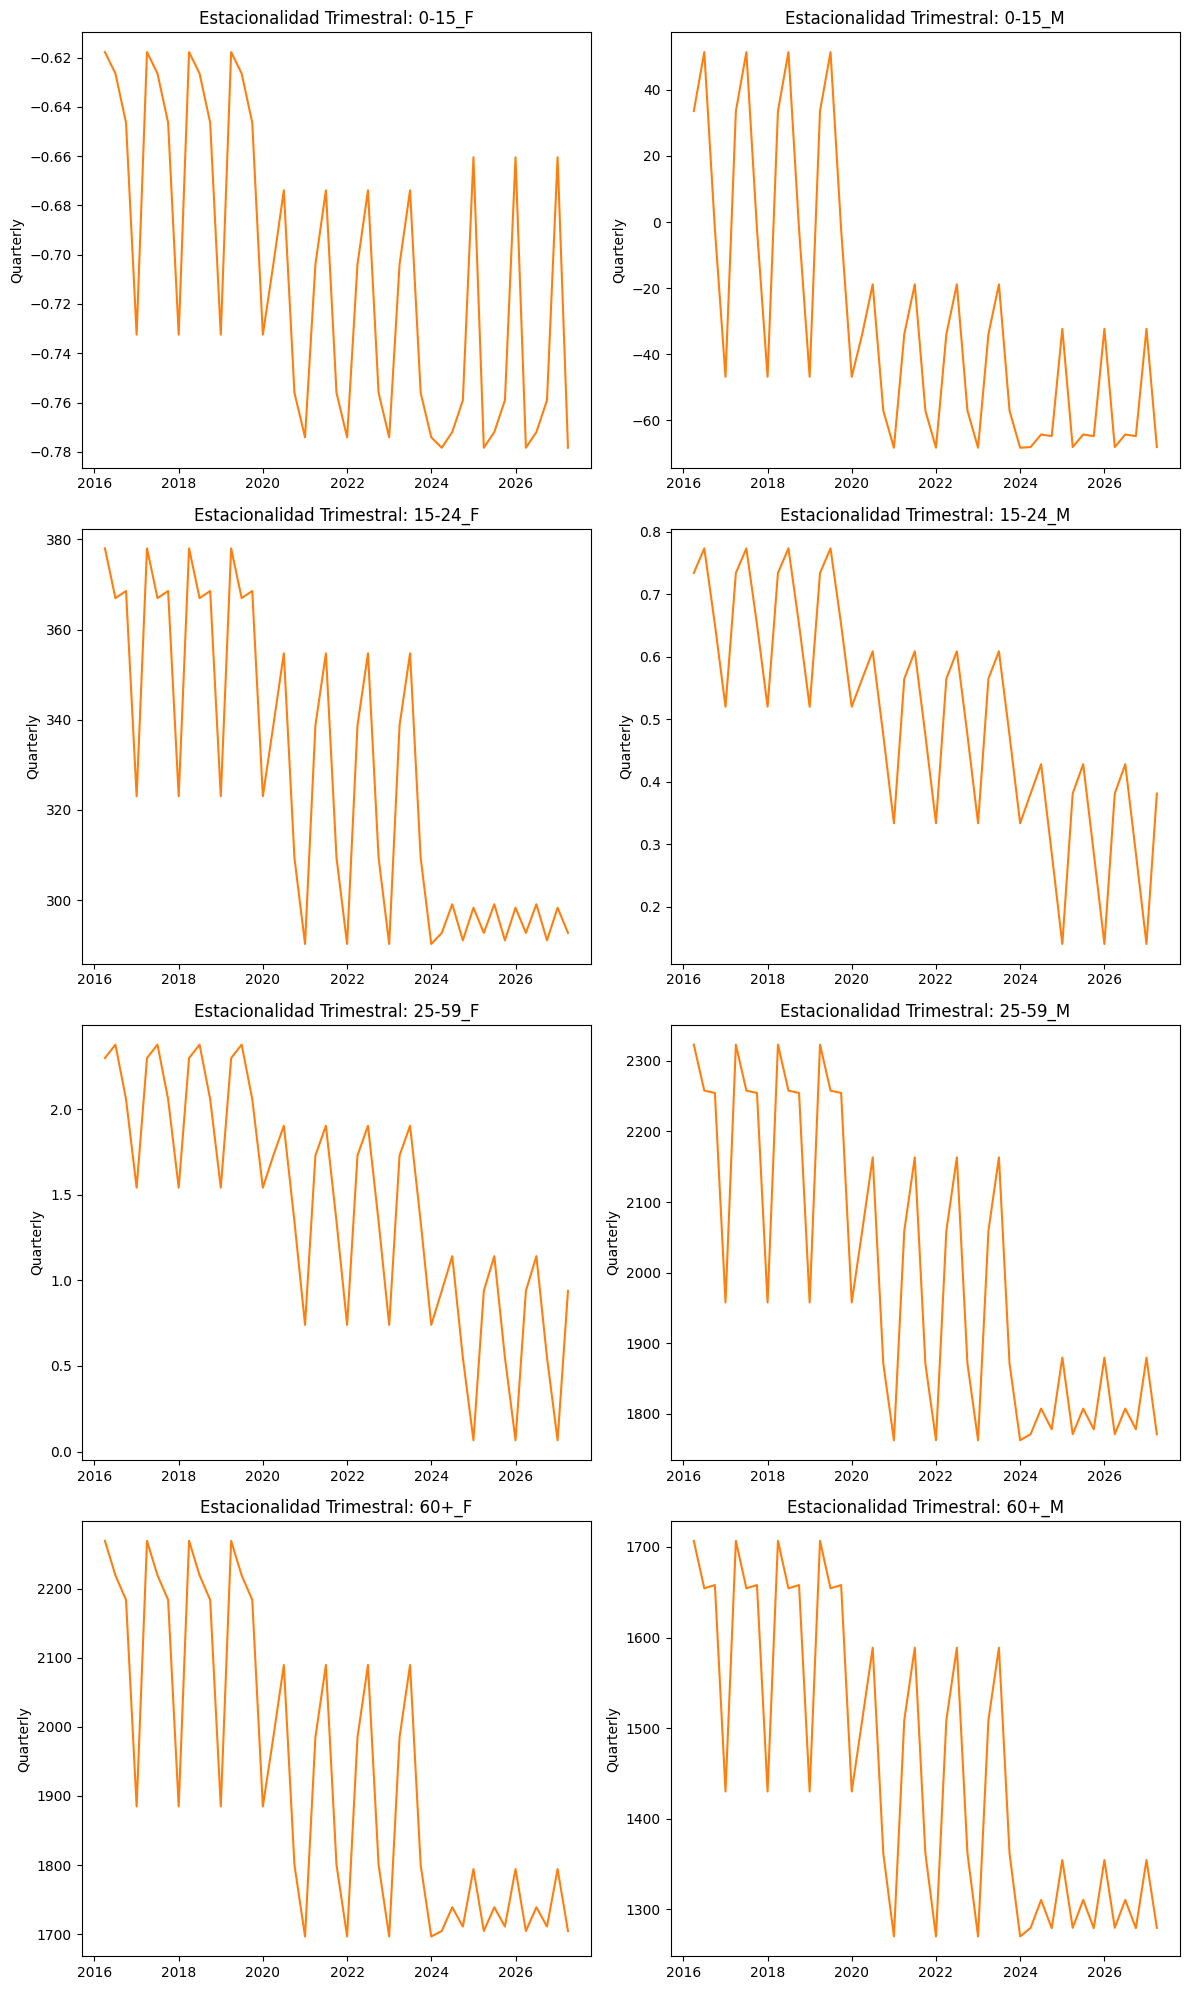

In [4]:
df = pd.read_csv(
    '/content/drive/MyDrive/PDS/pemex_trimestres_all.csv',
    parse_dates=['periodo']
)
df['periodo'] = (
    pd.to_datetime(df['periodo'])
      .dt.to_period('Q')
      .dt.to_timestamp(how='end')
)
# Formato Prophet
df_prop = df.rename(columns={'periodo':'ds','cronicas':'y'})[['ds','grupo','y']]
groups = df_prop['grupo'].unique()
n_test = 4   # hold-out últimos 4 trimestres

# 2) Hiperparámetros óptimos (del grid-search)
best_params = {
  '0-15_F':   {'cps':0.01, 'sps':5.0,  'fo':10, 'mode':'multiplicative'},
  '0-15_M':   {'cps':0.10, 'sps':1.0,  'fo':10, 'mode':'additive'},
  '15-24_F':  {'cps':0.01, 'sps':10.0, 'fo':10, 'mode':'additive'},
  '15-24_M':  {'cps':0.50, 'sps':1.0,  'fo':3,  'mode':'multiplicative'},
  '25-59_F':  {'cps':0.50, 'sps':1.0,  'fo':10, 'mode':'multiplicative'},
  '25-59_M':  {'cps':0.10, 'sps':10.0, 'fo':10, 'mode':'additive'},
  '60+_F':    {'cps':0.10, 'sps':10.0, 'fo':10, 'mode':'additive'},
  '60+_M':    {'cps':0.10, 'sps':10.0, 'fo':10, 'mode':'additive'},
}

# 3) Hold-out validation + pronóstico final
metrics      = []
lista_fc     = []
models_full  = {}
forecasts_full = {}

for grupo in groups:
    cfg   = best_params[grupo]
    df_g  = df_prop[df_prop['grupo']==grupo].reset_index(drop=True)
    train = df_g.iloc[:-n_test]
    test  = df_g.iloc[-n_test:]

    # 3.1) Validación (train → test)
    m_val = Prophet(
        seasonality_mode=cfg['mode'],
        changepoint_prior_scale=cfg['cps'],
        seasonality_prior_scale=cfg['sps'],
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    m_val.add_seasonality('quarterly', period=91.25, fourier_order=cfg['fo'])
    m_val.fit(train[['ds','y']])

    future_val = m_val.make_future_dataframe(periods=n_test, freq='Q')
    fc_val     = m_val.predict(future_val).set_index('ds')
    y_true     = test['y'].values
    y_hat      = fc_val.loc[test['ds'], 'yhat'].values

    mae  = mean_absolute_error(y_true, y_hat)
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    mape = np.mean(np.abs((y_true - y_hat) / (y_true + 1e-6))) * 100

    metrics.append({
        'grupo':      grupo,
        'MAE(test)':  round(mae,3),
        'RMSE(test)': round(rmse,3),
        'MAPE(test)': round(mape,2)
    })

    # 3.2) Pronóstico final (ajuste completo + 8 trimestres)
    m_full = Prophet(
        seasonality_mode=cfg['mode'],
        changepoint_prior_scale=cfg['cps'],
        seasonality_prior_scale=cfg['sps'],
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    m_full.add_seasonality('quarterly', period=91.25, fourier_order=cfg['fo'])
    m_full.fit(df_g[['ds','y']])

    future_full   = m_full.make_future_dataframe(periods=8, freq='Q')
    fc_full       = m_full.predict(future_full)

    # guardar para el grid de plots
    models_full[grupo]    = m_full
    forecasts_full[grupo] = fc_full

    # enganchar continuidad al main chart
    last   = df_g.iloc[[-1]]
    last_fc= pd.DataFrame({
        'ds':          last['ds'].values,
        'yhat':        last['y'].values,
        'yhat_lower':  last['y'].values,
        'yhat_upper':  last['y'].values
    })
    tail_fc = fc_full[['ds','yhat','yhat_lower','yhat_upper']].tail(8).reset_index(drop=True)
    df_fc   = pd.concat([last_fc, tail_fc], ignore_index=True)
    df_fc['grupo'] = grupo
    lista_fc.append(df_fc)

# 4) Mostrar métricas de validación
df_met = pd.DataFrame(metrics)
print("\nValidación Prophet (mejorado por grupo):")
print(df_met.to_string(index=False))

# 5) Gráfica maestra Histórico vs Pronóstico
df_plot_fc = pd.concat(lista_fc, ignore_index=True)
df_plot_fc.rename(columns={
    'ds':'periodo','yhat':'prediccion',
    'yhat_lower':'limite_inferior','yhat_upper':'limite_superior'
}, inplace=True)

plt.figure(figsize=(18,9))
for grupo in groups:
    hist = df_prop[df_prop['grupo']==grupo]
    fcg  = df_plot_fc[df_plot_fc['grupo']==grupo]
    plt.plot(hist['ds'], hist['y'],     label=f'{grupo} histórico')
    plt.plot(fcg['periodo'], fcg['prediccion'],
             '--', label=f'{grupo} pronóstico')
    plt.fill_between(
        fcg['periodo'],
        fcg['limite_inferior'],
        fcg['limite_superior'],
        alpha=0.15
    )

plt.title('Predicciones con "Prophet" por Grupo')
plt.xlabel('Periodo')
plt.ylabel('Casos de Enfermedades Crónicas')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

# 6) Grid de gráficas “oficiales” de Prophet por grupo
n = len(groups)
cols = 2
rows = (n + cols - 1)//cols
fig, axes = plt.subplots(rows, cols, figsize=(12, 5*rows))
axes = axes.flatten()

for ax, grupo in zip(axes, groups):
    m   = models_full[grupo]
    fc  = forecasts_full[grupo]
    m.plot(fc, ax=ax)
    ax.set_title(grupo)
    ax.set_xlabel('')
    ax.set_ylabel('')

# ocultar ejes sobrantes
for ax in axes[len(groups):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

# 7) Grid de tendencia (trend)
fig, axes = plt.subplots(rows, cols, figsize=(12, 5*rows))
axes = axes.flatten()

for ax, grupo in zip(axes, groups):
    fc = forecasts_full[grupo]
    ax.plot(fc['ds'], fc['trend'], color='tab:blue')
    ax.set_title(f"Tendencia: {grupo}")
    ax.set_xlabel('')
    ax.set_ylabel('Trend')

for ax in axes[n:]: ax.set_visible(False)
plt.tight_layout()
plt.show()


# 8) Grid de estacionalidad trimestral (columna 'quarterly')
fig, axes = plt.subplots(rows, cols, figsize=(12, 5*rows))
axes = axes.flatten()

for ax, grupo in zip(axes, groups):
    fc = forecasts_full[grupo]
    # aquí usamos 'quarterly' en vez de 'seasonal'
    ax.plot(fc['ds'], fc['quarterly'], color='tab:orange')
    ax.set_title(f"Estacionalidad Trimestral: {grupo}")
    ax.set_xlabel('')
    ax.set_ylabel('Quarterly')

for ax in axes[n:]: ax.set_visible(False)
plt.tight_layout()
plt.show()

#se guardan los resultados de prophet
df_plot_fc.to_csv('/content/drive/MyDrive/PDS/pronostico_prophet.csv', index=False)
#se guardan las metricas de prophet
df_met.to_csv('/content/drive/MyDrive/PDS/metricas_prophet.csv', index=True)
